# Part1. 데이터 불러오기, 문제정의, EDA&전처리

## 1.데이터셋 불러오기

In [ ]:
!pip3 install xgboost
!pip3 install lightgbm
!pip3 install catboost
!pip3 install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import learning_curve

plt.style.use('seaborn-whitegrid')

In [ ]:
# https://www.kaggle.com/datasets/stefanoleone992/fifa-21-complete-player-dataset
## sofifa 선수 스텟 데이터-> 명성, 잠재력의 수치화 된 변수를 갖고 오기 위해 사용
player18 = pd.read_csv('/content/drive/MyDrive/players_18.csv', usecols= ['short_name', 'age' ,'international_reputation', 'potential'])
player19 = pd.read_csv('/content/drive/MyDrive/players_19.csv', usecols= ['short_name', 'age' ,'international_reputation', 'potential'])
player20 = pd.read_csv('/content/drive/MyDrive/players_20.csv', usecols= ['short_name', 'age' ,'international_reputation', 'potential'])
#https://www.kaggle.com/datasets/kriegsmaschine/soccer-players-values-and-their-statistics
## fbref 선수 기록, 가치(value{Target}) 데이터 셋 
trans18 = pd.read_csv('/content/drive/MyDrive/transfermarkt_fbref_201718.csv',sep=';')
trans19 = pd.read_csv('/content/drive/MyDrive/transfermarkt_fbref_201819.csv',sep=';')
trans20 = pd.read_csv('/content/drive/MyDrive/transfermarkt_fbref_201920.csv',sep=';')
# player 데이터셋과 fbref 데이터셋의 이름 표기가 달라서 크롤링 해준 데이터셋
## trans18로 학습 및 분석을 진행 할 것인데 필요한 명성, 잠재력, 개인기 능력 등을 병합해 주기 위해서 생성
player_name18 = pd.read_csv('/content/drive/MyDrive/player_name18.csv',index_col=0)
player_name19 = pd.read_csv('/content/drive/MyDrive/player_name19.csv',index_col=0)
player_name20 = pd.read_csv('/content/drive/MyDrive/player_name20.csv',index_col=0)
# 프리미어 리그 경기에 결과와 기록에 대한 데이터셋
match = pd.read_csv('/content/drive/MyDrive/df_full_premierleague.csv',index_col=0)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (395) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# trans19 데이터의 경우 뒤에서 132번째 로우까지 대부분 결측치를 갖기때문에 해당 로우를 제거 하고 사용
trans19[-132:]

,Column1,player,nationality,position,squad,age,birth_year,value,height,position2,...,Pts/G,xG,xGA,xGDiff,xGDiff/90,Attendance,CL,WinCL,CLBestScorer,Season
2100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
2101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
2102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
2103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
2104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
2228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
2229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
2230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN


In [ ]:
trans19=trans19[:-132]

우선 분석을 위한 데이터셋에 명성, 개인기, 잠재력 변수를 가져와준다.

In [ ]:
player_name18.columns = ['player','age','short_name']

In [ ]:
player_name18.isnull().sum()

player          0
age             0
short_name    112
dtype: int64

In [ ]:
player_name18.dropna(inplace=True)

In [ ]:
for_merge18 = pd.merge(player_name18, player18, how='left', on='short_name')

In [ ]:
for_merge18.columns 

Index(['player', 'age_x', 'short_name', 'age_y', 'potential',
       'international_reputation'],
      dtype='object')

In [ ]:
# 중복 feature와 병합에 불필요한 feature를 제거해준다.
for_merge18.drop(['age_x','age_y','short_name'], axis=1,inplace=True)

In [ ]:
raw_df18 = pd.merge(trans18, for_merge18, how='left', on='player')

In [ ]:
raw_df18.head()

,Unnamed: 0,player,nationality,position,squad,age,birth_year,value,height,position2,...,xGA,xGDiff,xGDiff/90,Attendance,CL,WinCL,CLBestScorer,Season,potential,international_reputation
0,379,Burgui,es ESP,"FW,MF",Alavés,23,1993,1800000,186,attack - Left Winger,...,53.2,-14.2,-0.37,"16,819",0,0,0,201718#,80.0,1.0
1,2530,Raphaël Varane,fr FRA,DF,Real Madrid,24,1993,70000000,191,Defender - Centre-Back,...,45.4,37.9,1.00,66161,1,1,0,201718#,92.0,3.0
2,721,Rubén Duarte,es ESP,DF,Alavés,21,1995,2000000,179,Defender - Left-Back,...,53.2,-14.2,-0.37,"16,819",0,0,0,201718#,NaN,NaN
3,2512,Samuel Umtiti,fr FRA,DF,Barcelona,23,1993,60000000,182,Defender - Centre-Back,...,41.1,37.2,0.98,66603,1,0,0,201718#,88.0,3.0
4,882,Manu García,es ESP,MF,Alavés,31,1986,1800000,183,midfield - Defensive Midfield,...,53.2,-14.2,-0.37,"16,819",0,0,0,201718#,NaN,NaN


18/19 시즌, 19/20 시즌 데이터도 같은 작업을 반복해준다.

In [ ]:
player_name19.columns = ['player','short_name','age']

In [ ]:
player_name19.isnull().sum()

player         0
short_name    71
age            0
dtype: int64

In [ ]:
player_name19.dropna(inplace=True)

In [ ]:
for_merge19 = pd.merge(player_name19, player19, how='left', on='short_name')

In [ ]:
for_merge19.columns 

Index(['player', 'short_name', 'age_x', 'age_y', 'potential',
       'international_reputation'],
      dtype='object')

In [ ]:
# 중복 feature와 병합에 불필요한 feature를 제거해준다.
for_merge19.drop(['age_x','age_y','short_name'], axis=1,inplace=True)

In [ ]:
raw_df19 = pd.merge(trans19, for_merge19, how='left', on='player')

In [ ]:
raw_df19.head()

,Column1,player,nationality,position,squad,age,birth_year,value,height,position2,...,xGA,xGDiff,xGDiff/90,Attendance,CL,WinCL,CLBestScorer,Season,potential,international_reputation
0,207.0,Borja Bastón,es ESP,FW,Alavés,25.0,1992.0,2000000.0,186.0,Forward - Centre-Forward,...,50.8,-13.5,-0.36,"17,295",0.0,0.0,0,201819#,NaN,NaN
1,363.0,Burgui,es ESP,"MF,FW",Alavés,24.0,1993.0,1500000.0,184.0,Forward - Left Winger,...,50.8,-13.5,-0.36,"17,295",0.0,0.0,0,201819#,80.0,1.0
2,399.0,Jonathan Calleri,ar ARG,FW,Alavés,24.0,1993.0,9000000.0,181.0,Forward - Centre-Forward,...,50.8,-13.5,-0.36,"17,295",0.0,0.0,0,201819#,NaN,NaN
3,704.0,Rubén Duarte,es ESP,DF,Alavés,22.0,1995.0,5000000.0,172.0,Defender - Left-Back,...,50.8,-13.5,-0.36,"17,295",0.0,0.0,0,201819#,NaN,NaN
4,738.0,Rodrigo Ely,br BRA,DF,Alavés,24.0,1993.0,2000000.0,188.0,Defender - Centre-Back,...,50.8,-13.5,-0.36,"17,295",0.0,0.0,0,201819#,79.0,1.0


18/19 시즌, 19/20 시즌 데이터도 같은 작업을 반복해준다.

In [ ]:
player_name20.columns = ['player','short_name','age']

In [ ]:
player_name20.isnull().sum()

player          0
short_name    777
age             0
dtype: int64

In [ ]:
player_name20.dropna(inplace=True)

In [ ]:
for_merge20 = pd.merge(player_name19, player20, how='left', on='short_name')

In [ ]:
for_merge20.columns 

Index(['player', 'short_name', 'age_x', 'age_y', 'potential',
       'international_reputation'],
      dtype='object')

In [ ]:
# 중복 feature와 병합에 불필요한 feature를 제거해준다.
for_merge20.drop(['age_x','age_y','short_name'], axis=1,inplace=True)

In [ ]:
raw_df20 = pd.merge(trans20, for_merge20, how='left', on='player')

In [ ]:
raw_df20.head()

,Column1,player,nationality,position,squad,age,birth_year,value,height,position2,...,xGA,xGDiff,xGDiff/90,Attendance,CL,WinCL,CLBestScorer,Season,potential,international_reputation
0,21,Martin Aguirregabiria,es ESP,DF,AlavĂ©s,23,1996,4000000,178,Defender - Right-Back,...,53.2,-16.2,-0.43,"12,177",0,0,0.0,201920#,NaN,NaN
1,390,Oliver Burke,sco SCO,"MF,FW",AlavĂ©s,22,1997,4000000,188,Forward - Right Winger,...,53.2,-16.2,-0.43,"12,177",0,0,0.0,201920#,NaN,NaN
2,430,VĂ­ctor Camarasa,es ESP,MF,AlavĂ©s,25,1994,4000000,183,Midfielder - Central Midfield,...,53.2,-16.2,-0.43,"12,177",0,0,0.0,201920#,NaN,NaN
3,737,RubĂ©n Duarte,es ESP,DF,AlavĂ©s,23,1995,4000000,172,Defender - Left-Back,...,53.2,-16.2,-0.43,"12,177",0,0,0.0,201920#,NaN,NaN
4,770,Rodrigo Ely,br BRA,DF,AlavĂ©s,25,1993,1000000,188,Defender - Centre-Back,...,53.2,-16.2,-0.43,"12,177",0,0,0.0,201920#,79.0,1.0


첫번째 칼럼은 세 데이터 모두 선수 아이디로 보여짐 -> 제거 

In [ ]:
df18 = raw_df18.iloc[:,1:]
df19 = raw_df19.iloc[:,1:]
df20 = raw_df20.iloc[:,1:]

중복셀 확인

In [ ]:
print(df18.duplicated(subset=['player','value']).sum(),df19.duplicated(subset=['player','value']).sum(),df20.duplicated(subset=['player','value']).sum() )

491 478 312


In [ ]:
df18 =df18.drop_duplicates(subset=['player','value']).reset_index()
df19 =df19.drop_duplicates(subset=['player','value']).reset_index()
df20 =df20.drop_duplicates(subset=['player','value']).reset_index()

In [ ]:
print(df18.duplicated(subset=['player','value']).sum(),df19.duplicated(subset=['player','value']).sum(),df20.duplicated(subset=['player','value']).sum() )

0 0 0


In [ ]:
## 분석을 위한 데이터의 크기 
print('17/18 시즌 데이터셋 크기',df18.shape)
print('18/19 시즌 데이터셋 크기',df19.shape)
print('19/20 시즌 데이터셋 크기',df20.shape)

17/18 시즌 데이터셋 크기 (2118, 402)
18/19 시즌 데이터셋 크기 (2002, 402)
19/20 시즌 데이터셋 크기 (2526, 402)


## 2.문제정의

### 데이터 셋의 feature **확인**

In [ ]:
print('df18과 df19의 column이 모두 같은가??',all(df18.columns == df19.columns))
print('df19과 df20의 column이 모두 같은가??',all(df19.columns == df20.columns))

df18과 df19의 column이 모두 같은가?? True
df19과 df20의 column이 모두 같은가?? True


모두 같다.

feature는 400개로 매우 많기 때문에 포지션별로 중요한 feature를 선정하여 모델할 필요가 있다.


In [ ]:
for idx,col in enumerate(df18.columns):
    print(col, end=' ')
    if idx%10 ==9:
        print('\n')

index player nationality position squad age birth_year value height position2 

foot league games games_starts minutes goals assists pens_made pens_att cards_yellow 

cards_red goals_per90 assists_per90 goals_assists_per90 goals_pens_per90 goals_assists_pens_per90 xg npxg xa xg_per90 

xa_per90 xg_xa_per90 npxg_per90 npxg_xa_per90 minutes_90s shots_total shots_on_target shots_free_kicks shots_on_target_pct shots_total_per90 

shots_on_target_per90 goals_per_shot goals_per_shot_on_target npxg_per_shot xg_net npxg_net passes_completed passes passes_pct passes_total_distance 

passes_progressive_distance passes_completed_short passes_short passes_pct_short passes_completed_medium passes_medium passes_pct_medium passes_completed_long passes_long passes_pct_long 

xa_net assisted_shots passes_into_final_third passes_into_penalty_area crosses_into_penalty_area progressive_passes passes_live passes_dead passes_free_kicks through_balls 

passes_pressure passes_switches crosses corner_kicks cor

확인해 보면 출장 시간이나 선수의 포지션에 대한 정보 

그리고 포지션별 중요 기록들에 대한 정보가 있다.

중요한 기타변수 들이 있다.
EX)
- FW : Goal , xg, shot, dribbled, ...
- MF : passes, xa, dribbled, ...
- DF : tackle, pressure, block, ...
- GK : gk, clean_sheet, savedm,...

- Misc : league, card, ...

문제 정의: 맨체스터 유나이티드에서 20/21 시즌을 위해 영입해야할 선수는???
- 분석1: 팀 전술에 대한 파악 
- 분석2: 선수들의 기록과 기타 요소들을 보고 팀에 필요한 선수를 파악
- 모델링 : value(선수의 가치)를 target으로 하는 회귀 모델 생성
- 필요성: 구단이 선수를 영입할때 있어 적정한 이적료와 팀 전술에 얼마나 적합할지 파악해야 하니 필요한 절차라고 할 수 있다.  

### 포지션별 변수 구성

In [ ]:
# General
## 일반 선수 정보
standard = ['player', 'nationality', 'foot','position', 'height' , 'squad', 'age', 'international_reputation', 'potential','Season',"passes_left_foot","passes_right_foot"]
## 경기 출전
participation = ['games', 'games_starts', 'minutes']
## 타겟
target ='value'

In [ ]:
#Offense
## shooting
shooting = ["goals","pens_made","pens_att","shots_total","shots_free_kicks","shots_on_target","shots_on_target_pct","shots_total_per90","shots_on_target_per90","goals_per_shot","goals_per_shot_on_target","xg","npxg","npxg_per_shot","xg_net","npxg_net","shots_free_kicks"]
#goal and shot creation(gca)
gca = ["sca","sca_per90","sca_passes_live","sca_passes_dead","sca_dribbles","sca_shots","sca_fouled","gca","gca_per90","gca_passes_live","gca_passes_dead","gca_dribbles","gca_shots","gca_fouled"]
## passing
passing = ["passes","passes_pct","passes_total_distance","passes_progressive_distance","passes_completed_short","passes_pct_short","passes_medium","passes_pct_medium","passes_long","passes_pct_long","assists","xa","xa_net","assisted_shots","passes_into_final_third","passes_into_penalty_area","crosses_into_penalty_area","progressive_passes"]
##passtypes(passing_types)
passing_types = ["passes","passes_live","passes_dead","passes_free_kicks","through_balls","passes_switches","crosses","corner_kicks","corner_kicks_in","corner_kicks_out","corner_kicks_straight","passes_ground","passes_low","passes_high","passes_head","throw_ins","passes_other_body","passes_offsides","passes_oob","passes_pressure","passes_intercepted","passes_blocked"]

In [ ]:
# defence
##defensive actions(defense)
defense = ["tackles","tackles_won","tackles_def_3rd","tackles_mid_3rd","tackles_att_3rd","dribble_tackles","dribbles_vs","dribble_tackles_pct","dribbled_past","pressures","pressure_regains","pressure_regain_pct","pressures_def_3rd","pressures_mid_3rd","pressures_att_3rd","blocks","blocked_shots","blocked_shots_saves","blocked_passes","interceptions","clearances","errors","aerials_won","aerials_lost","aerials_won_pct"]
## GK stat
keeper = ["goals_against_gk","goals_against_per90_gk","shots_on_target_against","saves","save_pct","wins_gk","draws_gk","losses_gk","clean_sheets","clean_sheets_pct","pens_att_gk","pens_allowed","pens_saved","pens_missed_gk","free_kick_goals_against_gk","corner_kick_goals_against_gk","own_goals_against_gk","psxg_gk","psnpxg_per_shot_on_target_against","psxg_net_per90_gk","passes_pct_launched_gk","passes_gk","passes_throws_gk","pct_passes_launched_gk","passes_length_avg_gk","goal_kick_length_avg","crosses_stopped_pct_gk","def_actions_outside_pen_area_per90_gk","avg_distance_def_actions_gk"]



In [ ]:
# possession(possession)
possession = ["touches","touches_def_pen_area","touches_def_3rd","touches_mid_3rd","touches_att_3rd","touches_att_pen_area","touches_live_ball","dribbles_completed","dribbles","dribbles_completed_pct","players_dribbled_past","nutmegs","carries","carry_distance","carry_progressive_distance","pass_targets","passes_received","passes_received_pct","miscontrols","dispossessed"]

In [ ]:
minus = ["cards_yellow","cards_red","cards_yellow_red","fouls","own_goals"]

In [ ]:
FW_col = list(set(standard + participation + shooting + gca + passing +passing_types+possession+minus))
MF_col = list(set(standard + participation + shooting + gca + passing +passing_types+defense+possession+minus))
DF_col = list(set(standard + participation + passing +passing_types+defense+possession+minus))
GK_col = list(set(standard + participation + keeper+minus))

### 가설 설정

골키퍼가 공을 잘 막고, 공격수가 골을 잘 넣고, 미드필더가 패스를 잘하고, 수비수가 수비를 잘하고, 주전이 후보보다 더 value가 높은건 당연하다.

따라서 전처리를 완료하고 시각화를 통해 다음을 확인해 볼 것이다.

1. 크롤링으로 추가한 변수 명성 잠재력에 각 변수에 따른 value평균에는 차이가 있을 것이다.

2. 17/18 시즌보다 18/19 시즌의 평균 value가 높을 것이다. 

3. 공격수와 미드필더의 경우 양발 잡이인 경우가 아닌 경우보다 value 클 것이다.

4. 포지션 별로 value의 차이가 있을 것이다.

## 3.EDA & 전처리

### 전처리

포지션을 보면 두개의 포지션을 갖은 사람이 있다. 
-> position2의 attack,Defender,midfield, Goalkeeper 를 보고 하나로 만들어준다.

In [ ]:
df18.head()

,index,player,nationality,position,squad,age,birth_year,value,height,position2,...,xGA,xGDiff,xGDiff/90,Attendance,CL,WinCL,CLBestScorer,Season,potential,international_reputation
0,0,Burgui,es ESP,"FW,MF",Alavés,23,1993,1800000,186,attack - Left Winger,...,53.2,-14.2,-0.37,"16,819",0,0,0,201718#,80.0,1.0
1,1,Raphaël Varane,fr FRA,DF,Real Madrid,24,1993,70000000,191,Defender - Centre-Back,...,45.4,37.9,1.00,66161,1,1,0,201718#,92.0,3.0
2,2,Rubén Duarte,es ESP,DF,Alavés,21,1995,2000000,179,Defender - Left-Back,...,53.2,-14.2,-0.37,"16,819",0,0,0,201718#,NaN,NaN
3,3,Samuel Umtiti,fr FRA,DF,Barcelona,23,1993,60000000,182,Defender - Centre-Back,...,41.1,37.2,0.98,66603,1,0,0,201718#,88.0,3.0
4,4,Manu García,es ESP,MF,Alavés,31,1986,1800000,183,midfield - Defensive Midfield,...,53.2,-14.2,-0.37,"16,819",0,0,0,201718#,NaN,NaN


In [ ]:
def one_postion(x):
    position = x.split('-')[0].strip()
    if position in ['attack','Forward']:
        return 'FW'
    elif position == 'Defender':
        return 'DF'
    elif position in ['midfield','Midfielder']:
        return 'MF'        
    elif position == 'Goalkeeper':
        return 'GK'        

df18['position'] = df18['position2'].apply(lambda x:one_postion(x))
df19['position'] = df19['position2'].apply(lambda x:one_postion(x))
df20['position'] = df20['position2'].apply(lambda x:one_postion(x))

### 사용할 변수만 남겨주고 train(17/18, 18/19), test(19/20)으로 분할

In [ ]:
train = pd.concat([df18, df19])[list(set(FW_col+MF_col+DF_col+GK_col+[target]))].reset_index(drop=True)
test_X = df20[list(set(FW_col+MF_col+DF_col+GK_col))].reset_index(drop=True)
test_y = df20[target].reset_index(drop=True)

### 결측치 처리

In [ ]:
print('train set 결측치')
print(train.isnull().sum()[train.isnull().sum()>1],'\n\n')
print('test set 결측치')
print(test_X.isnull().sum()[test_X.isnull().sum()>1])

train set 결측치
foot                          7
potential                   904
international_reputation    904
dtype: int64 


test set 결측치
foot                          15
potential                   1388
international_reputation    1388
dtype: int64


#### foot
-> passes_left_foot 보다 passes_right_foot가 크거나 같으면 오른발 아니면 왼발로 처리

In [ ]:
def fill_foot(df):
    null_idx = df[df['foot'].isnull()].index
    df.loc[null_idx,'foot'] = (df.loc[null_idx,'passes_left_foot']<=df.loc[null_idx,'passes_right_foot']).astype('int').map({0:'left',1:'right'})
    return df

In [ ]:
for df in [train,test_X]:
    fill_foot(df)

In [ ]:
print('train set 결측치')
print(train.isnull().sum()[train.isnull().sum()>1],'\n\n')
print('test set 결측치')
print(test_X.isnull().sum()[test_X.isnull().sum()>1])

train set 결측치
potential                   904
international_reputation    904
dtype: int64 


test set 결측치
potential                   1388
international_reputation    1388
dtype: int64


#### potential, international_reputation

In [ ]:
train_Team_Potential=train.groupby('squad')['potential'].mean().reset_index()

In [ ]:
train_Team_Potential = train_Team_Potential.sort_values(by='potential')

In [ ]:
train_Team_Potential = pd.concat([train_Team_Potential.head(),train_Team_Potential.tail()],axis=0)

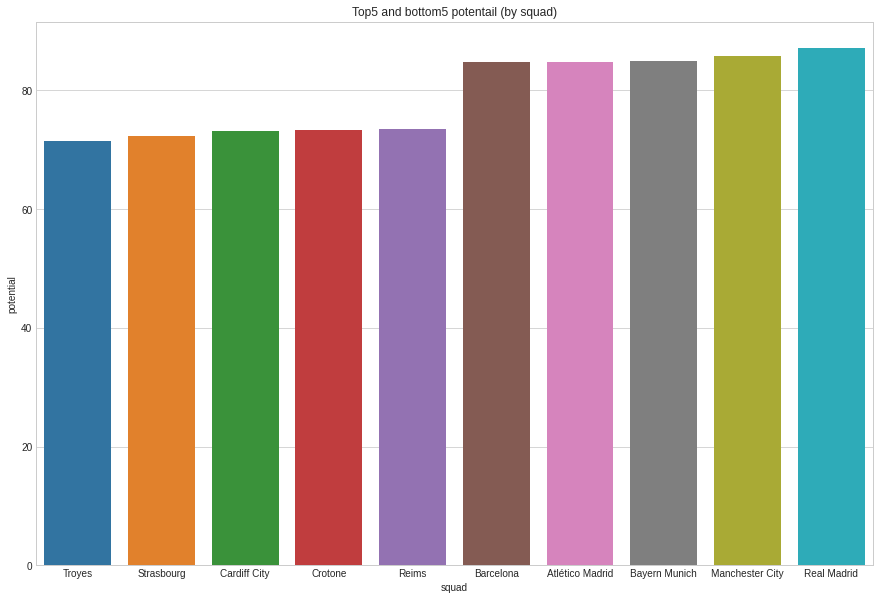

In [ ]:
plt.figure(figsize=(15,10))
plt.title('Top5 and bottom5 potentail (by squad)')
sns.barplot(x='squad', y='potential' , data= train_Team_Potential)

In [ ]:
train_Team_Potential=train.groupby('squad')['international_reputation'].median().reset_index()

In [ ]:
train_Team_Potential = train_Team_Potential.sort_values(by='international_reputation')

In [ ]:
train_Team_Potential = pd.concat([train_Team_Potential.head(),train_Team_Potential.tail()],axis=0)

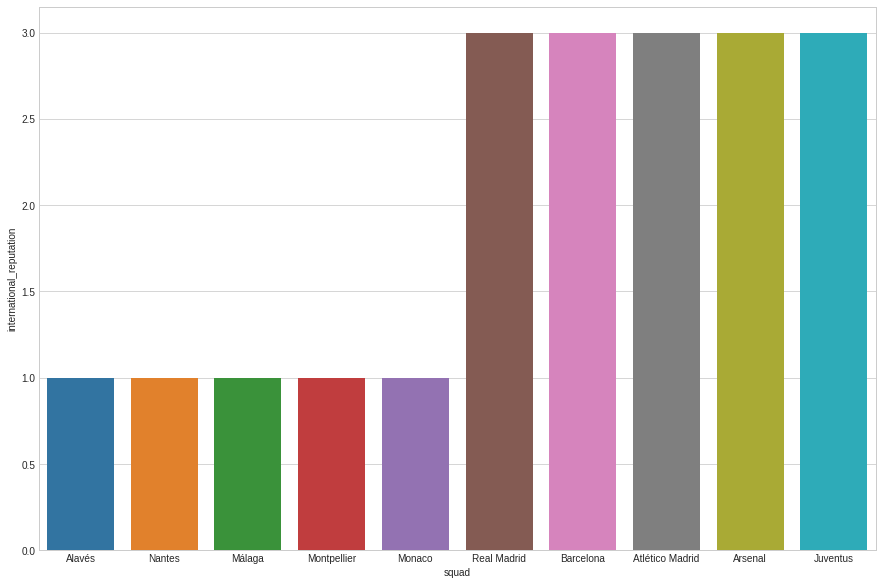

In [ ]:
plt.figure(figsize=(15,10))
sns.barplot(x='squad', y='international_reputation' , data= train_Team_Potential)

In [ ]:
# Hannover 96 표본이 적어서(한명 뿐이라 그래프에 high international_reputation group 으로 표시된걸로 보임)
train[train['squad']=='Hannover 96']['player']

1946            Felipe
2945    Kevin Akpoguma
2946      Takuma Asano
2947            Felipe
Name: player, dtype: object

In [ ]:
for squad in list(set(train['squad'].values)):
    team = train[train['squad']==squad]
    print(f'{squad}의 potential 결측치 비율: {round((len(team[team["potential"].isnull()])/len(team))*100,2)}')

Lyon의 potential 결측치 비율: 10.81
SPAL의 potential 결측치 비율: 12.77
Burnley의 potential 결측치 비율: 2.33
Frosinone의 potential 결측치 비율: 9.38
Caen의 potential 결측치 비율: 0.0
Parma의 potential 결측치 비율: 11.11
Strasbourg의 potential 결측치 비율: 21.95
RB Leipzig의 potential 결측치 비율: 11.9
Düsseldorf의 potential 결측치 비율: 11.11
Roma의 potential 결측치 비율: 12.2
Getafe의 potential 결측치 비율: 41.46
Genoa의 potential 결측치 비율: 26.42
Atlético Madrid의 potential 결측치 비율: 48.94
Villarreal의 potential 결측치 비율: 45.1
Angers의 potential 결측치 비율: 22.45
Watford의 potential 결측치 비율: 14.89
Juventus의 potential 결측치 비율: 21.28
Leicester City의 potential 결측치 비율: 4.17
Leganés의 potential 결측치 비율: 26.32
Stuttgart의 potential 결측치 비율: 33.33
Milan의 potential 결측치 비율: 17.07
Lille의 potential 결측치 비율: 37.78
M'Gladbach의 potential 결측치 비율: 12.2
Levante의 potential 결측치 비율: 35.56
Espanyol의 potential 결측치 비율: 53.49
Inter의 potential 결측치 비율: 25.0
Girona의 potential 결측치 비율: 20.93
Huesca의 potential 결측치 비율: 40.91
Crotone의 potential 결측치 비율: 12.5
Eint Frankfurt의 potential 결측치 비율: 22.22
Mars

In [ ]:
for squad in list(set(test_X['squad'].values)):
    team = test_X[test_X['squad']==squad]
    print(f'{squad}의 international_reputation 결측치 비율: {round((len(team[team["international_reputation"].isnull()])/len(team))*100,2)}')

Lyon의 international_reputation 결측치 비율: 44.0
SPAL의 international_reputation 결측치 비율: 33.33
Aston Villa의 international_reputation 결측치 비율: 81.48
Burnley의 international_reputation 결측치 비율: 25.0
NĂ®mes의 international_reputation 결측치 비율: 76.0
Brescia의 international_reputation 결측치 비율: 87.5
Parma의 international_reputation 결측치 비율: 24.0
Strasbourg의 international_reputation 결측치 비율: 52.38
RB Leipzig의 international_reputation 결측치 비율: 25.0
Roma의 international_reputation 결측치 비율: 39.29
Getafe의 international_reputation 결측치 비율: 55.56
Genoa의 international_reputation 결측치 비율: 39.29
AtlĂ©tico Madrid의 international_reputation 결측치 비율: 60.71
Villarreal의 international_reputation 결측치 비율: 52.38
Angers의 international_reputation 결측치 비율: 44.0
Watford의 international_reputation 결측치 비율: 33.33
Juventus의 international_reputation 결측치 비율: 34.48
Leicester City의 international_reputation 결측치 비율: 25.0
Mallorca의 international_reputation 결측치 비율: 96.43
Milan의 international_reputation 결측치 비율: 60.0
Lille의 international_reputation 결측치 

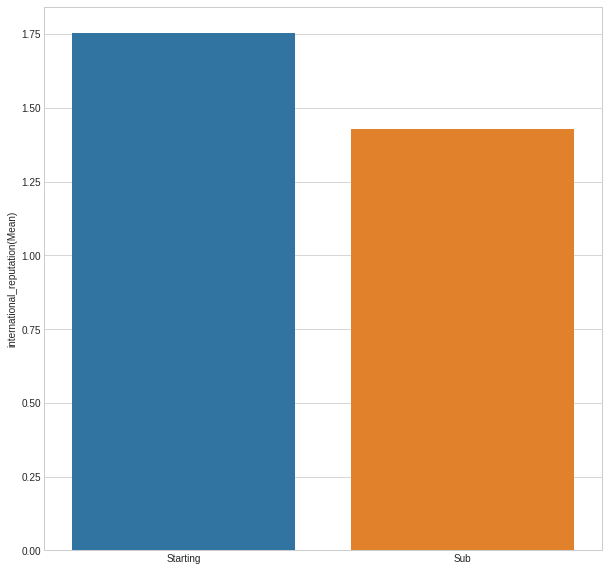

In [ ]:
starting= train[train['games_starts']>=19]
sub = train[train['games_starts']<19]
plt.figure(figsize=(10,10))
plt.ylabel('international_reputation(Mean)')
sns.barplot(x=['Starting','Sub'],y=[starting['international_reputation'].mean(),sub['international_reputation'].mean()])


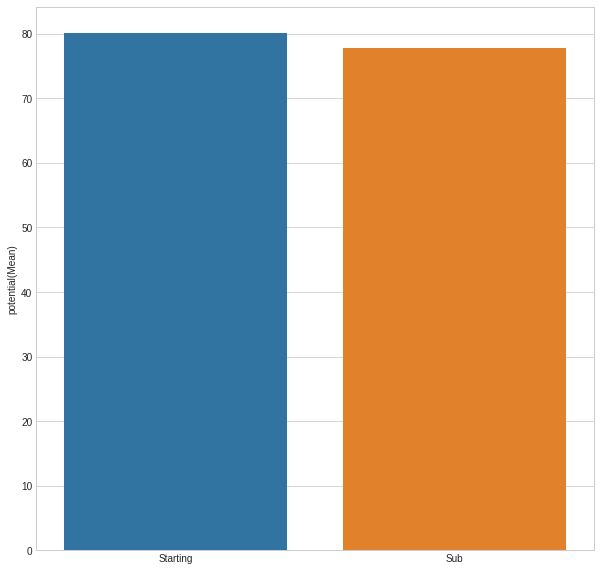

In [ ]:
plt.figure(figsize=(10,10))
plt.ylabel('potential(Mean)')
sns.barplot(x=['Starting','Sub'],y=[starting["potential"].mean(),sub["potential"].mean()])

potential의 경우 큰 차이는 없어보이지만 international_reputation의 경우는 어느정도 차이가 있어보인다.

팀별로 potential과 international_reputation에 차이가 있어보인다. -> 

- 우선 타 시즌에 대한 potential과 international_reputation 정보가 있다면 해당 값으로 결측치 처리해준다.

- 타 시즌에대한 정보다 없다면 potential 의 경우 mean값으로 international_reputation의 경우 median 값으로 대체해준다.(결측비율이 100%인 팀은 없으니 이 방법을 적용할 수 있어보인다.) [이때  international_reputatio의 경우선발선수와 후보 선수도 구분해서 처리한다.] 

In [ ]:
def starting(x):
    if x>=19:
        return 1
    else:
        return 0

In [ ]:
train['starting'] =  train['games_starts'].apply(lambda x:starting(x))
test_X['starting'] =  test_X['games_starts'].apply(lambda x:starting(x))

In [ ]:
rep_dict=dict(train.groupby('player')['international_reputation'].mean())
pot_dict=dict(train.groupby('player')['potential'].mean())

In [ ]:
def fill_pot_and_international_reputaion(pot_dict, rep_dict, df):
    null = df[df['potential'].isnull()]
    df.loc[null.index,'potential'] = df.loc[null.index,'player'].map(pot_dict)
    null = df[df['potential'].isnull()]
    pot_dict = dict(df.groupby('squad')['potential'].mean())
    for squad, potential in pot_dict.items():
        null_idx = null[null['squad']==squad].index
        df.loc[null_idx,'potential'] = potential
    null = df[df['international_reputation'].isnull()]
    df.loc[null.index,'international_reputation'] = df.loc[null.index,'player'].map(rep_dict)
    starting = df[df['starting']==1]
    sub = df[df['starting']==0]
    starting_null= starting[starting['international_reputation'].isnull()]
    sub_null= sub[sub['international_reputation'].isnull()]

    starting_rep_dict = dict(starting.groupby('squad')['international_reputation'].median())
    sub_rep_dict = dict(sub.groupby('squad')['international_reputation'].median())
    for squad, international_reputation in starting_rep_dict.items():
        starting_null_idx = starting_null[starting_null['squad']==squad].index
        df.loc[null_idx,'international_reputation'] = international_reputation
    for squad, international_reputation in sub_rep_dict.items():
        sub_null_idx = sub_null[sub_null['squad']==squad].index
        df.loc[null_idx,'international_reputation'] = international_reputation
    
    # 선수의 데이터가 적은 팀의 경우 결측치가 처리 안되는 경우가 있기 때문에 추가함
    null = df[df['international_reputation'].isnull()]
    rep_dict = dict(df.groupby('squad')['international_reputation'].median())
    for squad, international_reputation in rep_dict.items():
        null_idx = null[null['squad']==squad].index
        df.loc[null_idx,'international_reputation'] = international_reputation
    return df

In [ ]:
for df in [train, test_X]:
    fill_pot_and_international_reputaion(pot_dict, rep_dict, df)

In [ ]:
print('train set 결측치')
print(train.isnull().sum()[train.isnull().sum()>1],'\n\n')
print('test set 결측치')
print(test_X.isnull().sum()[test_X.isnull().sum()>1])

train set 결측치
Series([], dtype: int64) 


test set 결측치
Series([], dtype: int64)


결측치가 모두 제거 되었다.

### 시각화를 통한 가설 확인

#### 1-1. [가설] international_reputation별로 value의 차이가 있을 것이다.

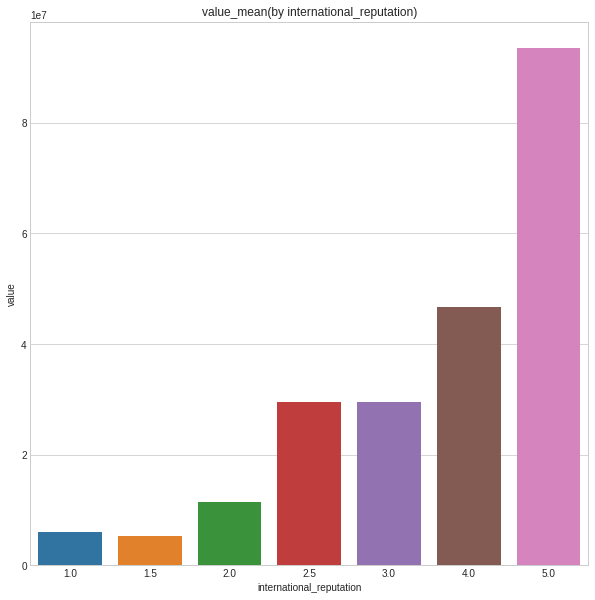

In [ ]:
for_graph = train.groupby('international_reputation')['value'].mean().reset_index()
plt.figure(figsize=(10,10))
plt.title('value_mean(by international_reputation)')
sns.barplot(x='international_reputation', y='value', data=for_graph)

1.0과 1.5에는 큰 차이가 없어보인다.
그 이후에는 international_reputation이 커질 수록 value는 커진다.


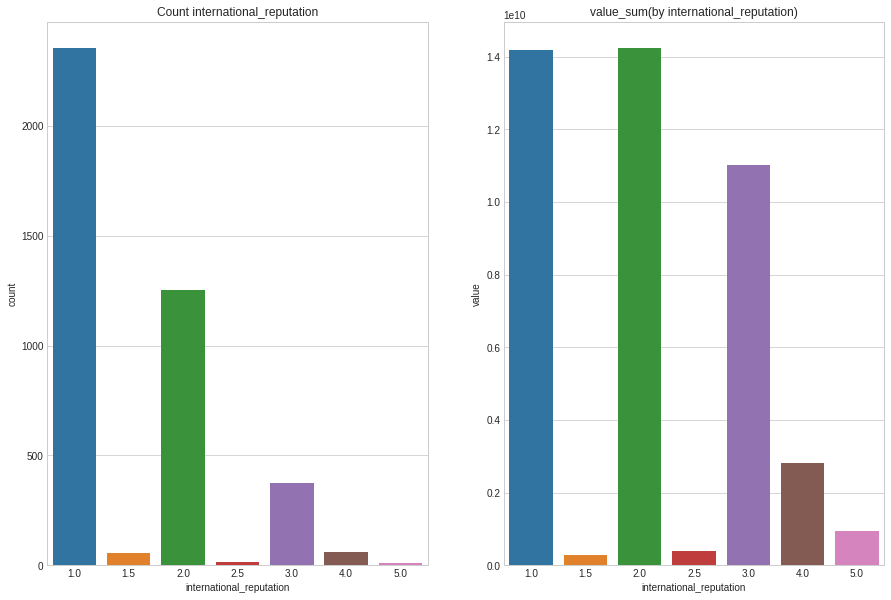

In [ ]:
for_graph = train.groupby('international_reputation').count().reset_index().rename({'value':'count'},axis=1)

plt.figure(figsize=(15,10))
ax =plt.subplot(121)
plt.title('Count international_reputation')
sns.barplot(x='international_reputation', y='count', data=for_graph)


for_graph = train.groupby('international_reputation').sum().reset_index()

plt.subplot(122)
plt.title('value_sum(by international_reputation)')
sns.barplot(x='international_reputation', y='value', data=for_graph)



데이터셋 대부분에는 international_reputation이 1과 2인 사람이 많다. 따라서 international_reputation별 value의 합을 봐보면 1과 2가 큰편에 속한다. 

=> 이전에 그렸던 international_reputation별 평균 그래프를 생각해보면
소수의 상위 international_reputation 선수가 다수의 하위 international_reputation 선수에 비해 압도적으로 높은 value를 갖음을 알 수 있다.

#### new_insight
international_reputation를 상,중,하로 두고 top 5 선수의 value를 봐본다면?

In [ ]:
Top_5 = train[train['international_reputation']>=3.5].sort_values(by='value', ascending= False)[['player','value']].drop_duplicates().head()
Middle_5 = train[train['international_reputation']==3].sort_values(by='value', ascending= False)[['player','value']].drop_duplicates().head()
# 시즌이 바뀌면서 reputation이 바뀐 선수 2명이 있어서 head(7)로 설정
Bottom_5 = train[train['international_reputation']<=2.5].sort_values(by='value', ascending= False)[['player','value']].drop_duplicates().head(7)

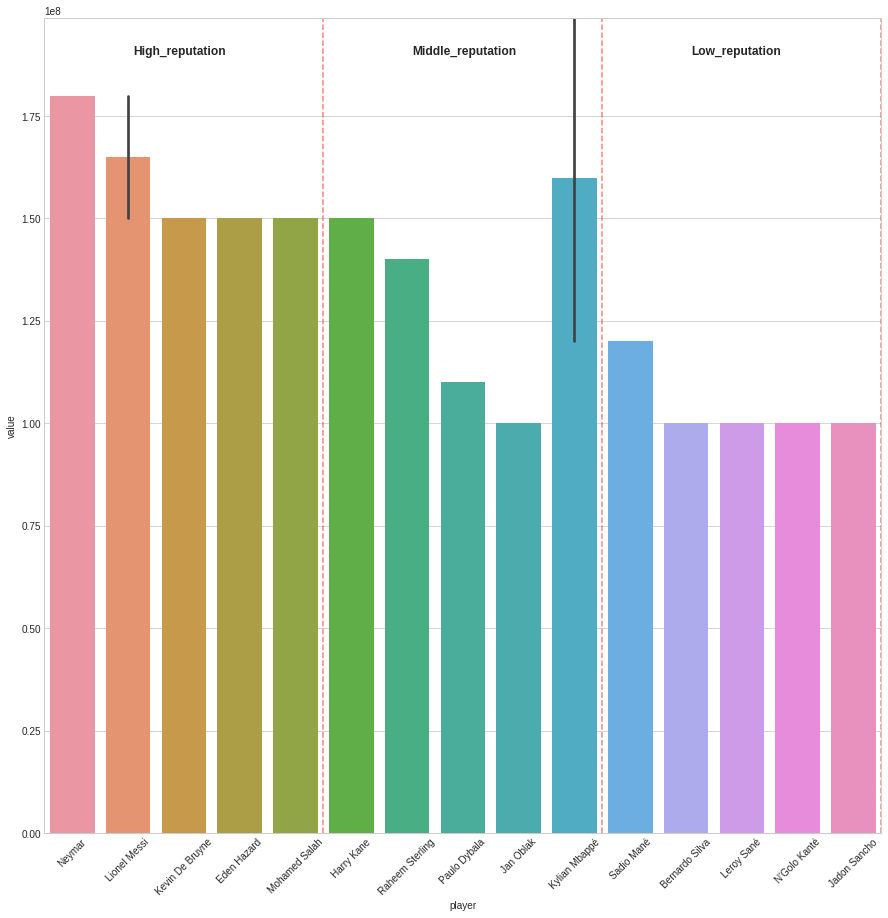

In [ ]:
for_graph = pd.concat([Top_5,Middle_5,Bottom_5])
plt.figure(figsize=(15,15))
g = sns.barplot(x='player' ,y='value', data=for_graph)
plt.setp(g.get_xticklabels(), rotation=45)
plt.ylim(0,1.99*1e8)
plt.axvline(4.5, linestyle = '--', color='r', alpha=0.5)
plt.axvline(9.5, linestyle = '--', color='r', alpha=0.5)
plt.axvline(14.5, linestyle = '--', color='r', alpha=0.5)
plt.text(x=1.1, y=1.9*1e8, s = 'High_reputation', fontweight='bold',fontsize=12)
plt.text(x=6.1, y=1.9*1e8, s = 'Middle_reputation', fontweight='bold',fontsize=12)
plt.text(x=11.1, y=1.9*1e8, s = 'Low_reputation', fontweight='bold',fontsize=12)
plt.show()

international_reputation 가 낮은 선수들도 value가 높은 경우가 있다. 이러한 경우는 대부분 유망주라서 베테랑 선수들에 비해 international_reputation이 낮아보인다. 유망주 feature를 따로 만들 필요가 있어보인다.(추후 포지션을 나누고 포지션별 기록과 나이를 보고 생성)

#### 1-2. [가설]potential별로 value의 차이가 있을것이다.

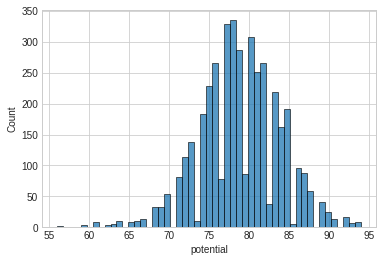

In [ ]:
sns.histplot(train.potential)

potential 변수를 10간격으로 Ordinal 변수로 변경

In [ ]:
def potential_ord(x):
    if x>=50 and x<60:
        return 5
    elif x>=60 and x<70:
        return 6
    elif x>=70 and x<80:
        return 7
    elif x>=80 and x<90:
        return 8
    elif x>=90 and x<100:
        return 9

In [ ]:
train.potential=train.potential.apply(lambda x:potential_ord(x))
test_X.potential=test_X.potential.apply(lambda x:potential_ord(x))

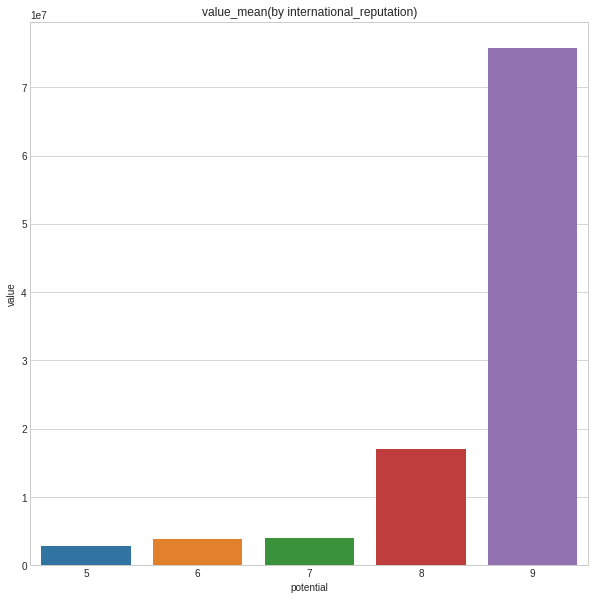

In [ ]:
for_graph = train.groupby('potential')['value'].mean().reset_index()
plt.figure(figsize=(10,10))
plt.title('value_mean(by international_reputation)')
sns.barplot(x='potential', y='value', data=for_graph)

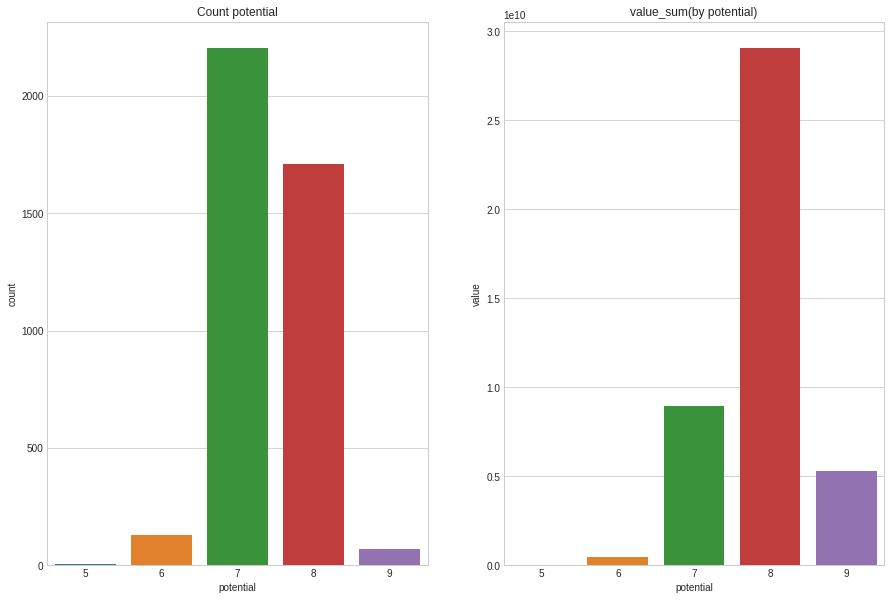

In [ ]:
for_graph = train.groupby('potential').count().reset_index().rename({'value':'count'},axis=1)

plt.figure(figsize=(15,10))
ax =plt.subplot(121)
plt.title('Count potential')
sns.barplot(x='potential', y='count', data=for_graph)


for_graph = train.groupby('potential').sum().reset_index()

plt.subplot(122)
plt.title('value_sum(by potential)')
sns.barplot(x='potential', y='value', data=for_graph)



데이터셋 대부분에는 potential이 7과 8인 사람이 많다. 따라서 potential별 value의 합을 봐보면 7과 8이 큰편에 속한다. 

=> 이전에 그렸던 potential별 평균 그래프를 생각해보면 potential이 높을 수록 높은 value를 갖는다. 특히 potential이 90대의 선수의 value 평균은 다른 potential을 갖는 선수들에 비해 매우 높다.


#### 1-3. 결론 
potential과 international_reputation이 높을 수록 평균 value가 높다.



#### 2-1. [가설]17/18 시즌보다 18/19 시즌의 평균 value가 높을 것이다. 

In [ ]:
S18 = train[train['Season'] == '201718#']
S19 = train[train['Season'] == '201819#']

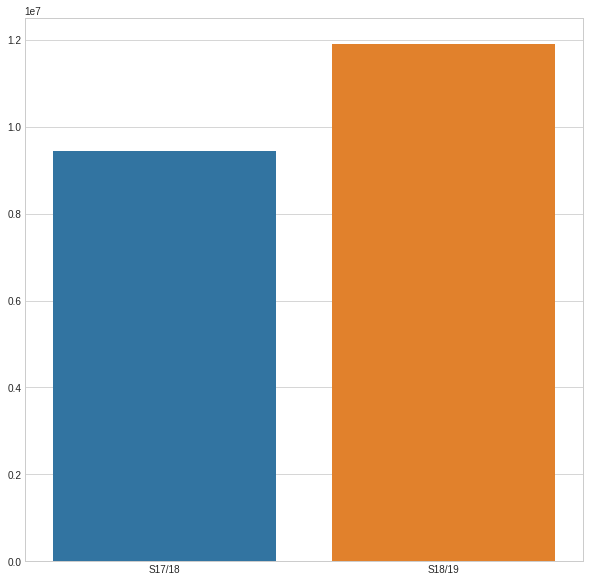

In [ ]:
plt.figure(figsize=(10,10))
sns.barplot(x = ['S17/18','S18/19'], y = [S18.value.mean(),S19.value.mean()] )

19 시즌의 value 평균이 더 높은 것을 확인 가능하다.

#### 2-2.결론 및 encoding

In [ ]:
train.Season = train.Season.map({'201718#':18,'201819#':19})
test_X.Season = test_X.Season.map({'201920#':20})

####   3-1 .[가설] 공격수와 미드필더의 경우 양발 잡이인 경우가 아닌 경우보다 평균 value 가 클것이다.

포지션별 분리

In [ ]:
FW = train.loc[train['position']=='FW',FW_col+[target]]
MF = train.loc[train['position']=='MF',MF_col+[target]]
DF = train.loc[train['position']=='DF',DF_col+[target]]
GK = train.loc[train['position']=='GK',GK_col+[target]]
FW_test_X = test_X.loc[test_X['position']=='FW',FW_col]
MF_test_X = test_X.loc[test_X['position']=='MF',MF_col]
DF_test_X = test_X.loc[test_X['position']=='DF',DF_col]
GK_test_X = test_X.loc[test_X['position']=='GK',GK_col]

In [ ]:
print('FW 데이터 크기: ',FW.shape)
print('MF 데이터 크기: ',MF.shape)
print('DF 데이터 크기: ',DF.shape)
print('GK 데이터 크기: ',GK.shape)
print('-'*20)
print('FW_test 데이터 크기: ',FW_test_X.shape)
print('MF_test 데이터 크기: ',MF_test_X.shape)
print('DF_test 데이터 크기: ',DF_test_X.shape)
print('GK_test 데이터 크기: ',GK_test_X.shape)

FW 데이터 크기:  (1175, 110)
MF 데이터 크기:  (1188, 134)
DF 데이터 크기:  (1422, 104)
GK 데이터 크기:  (335, 50)
--------------------
FW_test 데이터 크기:  (724, 109)
MF_test 데이터 크기:  (748, 133)
DF_test 데이터 크기:  (862, 103)
GK_test 데이터 크기:  (191, 49)


In [ ]:
print('FW')
print(FW.isnull().sum()[FW.isnull().sum()>1],'\n\n')
print('MF')
print(MF.isnull().sum()[MF.isnull().sum()>1],'\n\n')
print('DF')
print(DF.isnull().sum()[DF.isnull().sum()>1],'\n\n')
print('GK')
print(GK.isnull().sum()[GK.isnull().sum()>1],'\n\n')

print('-'*30)
print('FW_test')
print(FW_test_X.isnull().sum()[FW_test_X.isnull().sum()>1],'\n\n')
print('MF_test')
print(MF_test_X.isnull().sum()[MF_test_X.isnull().sum()>1],'\n\n')
print('DF_test')
print(DF_test_X.isnull().sum()[DF_test_X.isnull().sum()>1],'\n\n')
print('GK_test')
print(GK_test_X.isnull().sum()[GK_test_X.isnull().sum()>1],'\n\n')


FW
Series([], dtype: int64) 


MF
Series([], dtype: int64) 


DF
Series([], dtype: int64) 


GK
Series([], dtype: int64) 


------------------------------
FW_test
Series([], dtype: int64) 


MF_test
Series([], dtype: int64) 


DF_test
Series([], dtype: int64) 


GK_test
Series([], dtype: int64) 




In [ ]:
FW['both'] = FW['foot'].apply(lambda x: 1if x=='both' else 0 )
MF['both'] = MF['foot'].apply(lambda x: 1if x=='both' else 0 )
FW_test_X['both'] = FW_test_X['foot'].apply(lambda x: 1if x=='both' else 0 )
MF_test_X['both'] = MF_test_X['foot'].apply(lambda x: 1if x=='both' else 0 )

Text(0, 0.5, '')

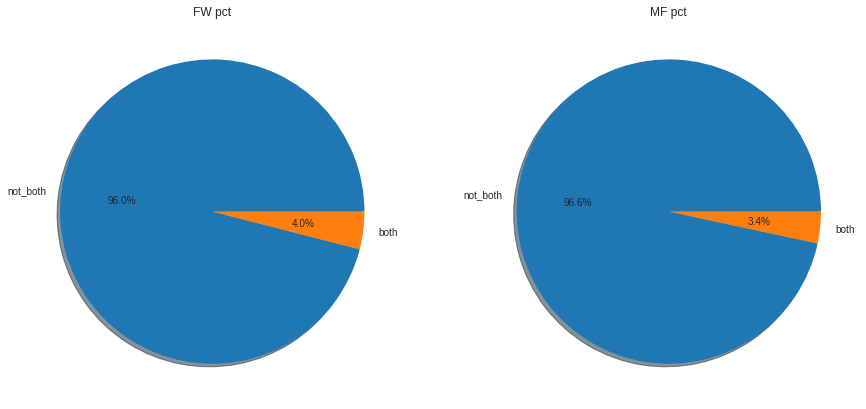

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.title('FW pct')
FW['both'].value_counts().plot.pie(autopct='%1.1f%%',labels=['not_both','both'] ,shadow=True).set_ylabel('')
plt.subplot(122)
plt.title('MF pct')
MF['both'].value_counts().plot.pie(autopct='%1.1f%%',labels=['not_both','both'] ,shadow=True).set_ylabel('')

소수의 선수가 양발잡이다.

양발의 선수는 공격시 선택폭이 많아지면서 수비하기 까다롭다는 장점이 이있다. 

그렇다면 양발잡이와 양발잡이가 아닌 경우 value의 차이가 있을지 확인해 보겠다.


In [ ]:
FW_both = FW[FW['foot']=='both']
FW_not_both = FW[FW['foot']!='both']
MF_both = MF[MF['foot']=='both']
MF_not_both = MF[MF['foot']!='both']

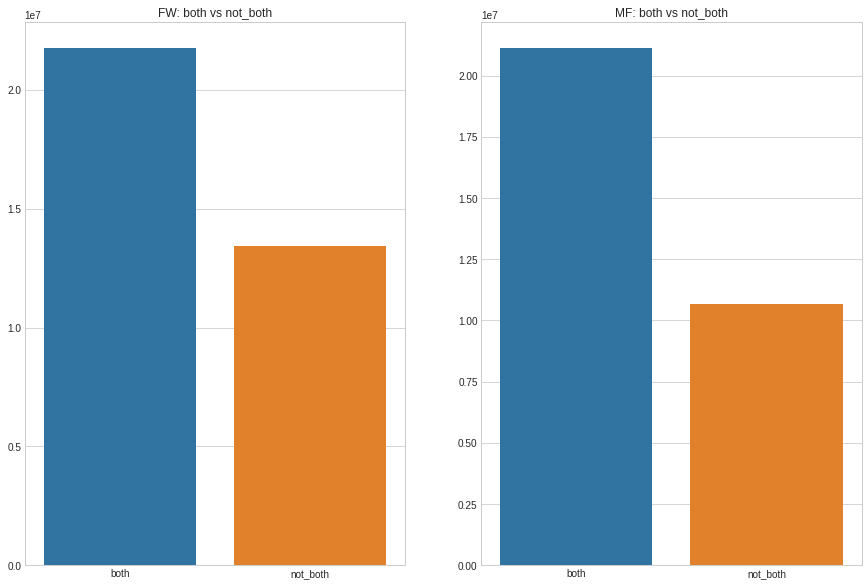

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.title('FW: both vs not_both')
sns.barplot(x=['both','not_both'], y=[FW_both.value.mean(),FW_not_both.value.mean()])
plt.subplot(122)
plt.title('MF: both vs not_both')
sns.barplot(x=['both','not_both'], y=[MF_both.value.mean(),MF_not_both.value.mean()])

#### 3-2.양발잡이인 선수가 양발잡이가 아닌 선수에 비해 평균 value가 높다는 것을 알 수 있다.

#### 3-3. 수비수도 그럴까???

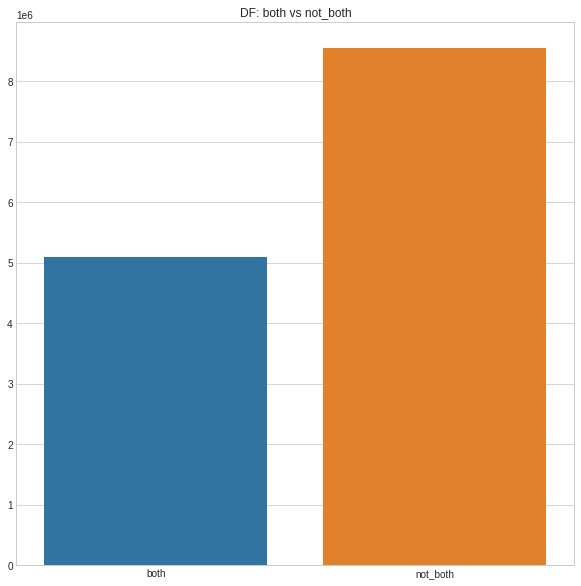

In [ ]:
DF_both = DF[DF['foot']=='both']
DF_not_both = DF[DF['foot']!='both']
plt.figure(figsize=(10,10))
plt.title('DF: both vs not_both')
sns.barplot(x=['both','not_both'], y=[DF_both.value.mean(),DF_not_both.value.mean()])

수비수는 오히려 양발 잡이가 더 낮다..

#### 3.4 결론 
FW,MF의 경우 양발잡이면 평균 value가 더 높다.

#### 4.1 [가설]포지션 별로 value의 차이가 있을 것이다.

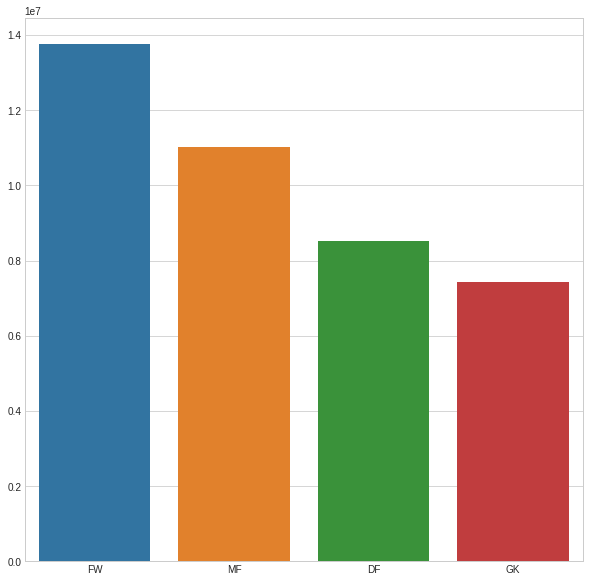

In [ ]:
plt.figure(figsize=(10,10))
sns.barplot(x = ['FW','MF','DF','GK'],y = [FW.value.mean(),MF.value.mean(),DF.value.mean(),GK.value.mean()])

필드 플레이어는 골키퍼에 비해 평균 value가 높고, 필드플레이어의 경우 FW>MF>DF 순으로 평균 value가 높다.

#### 4.2 결론
포지션에 따라 평균 value의 차이가 있다고 할 수 있다.

#### 유망주 feature 생성
age 23 이하의 선수중에 선택



#### FW

In [ ]:
FW['promising'] = 0
FW_under_age = FW[FW['age']<=23]

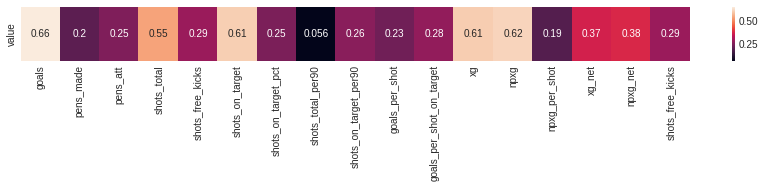

In [ ]:
# 슈팅
plt.figure(figsize=(15,1))
sns.heatmap(FW_under_age[shooting+['value']].corr().iloc[-1:,:-1],annot = True)

In [ ]:
shooting_top4 = FW_under_age[shooting+['value']].corr().iloc[-1,:-1].sort_values(ascending=False).index[:4]

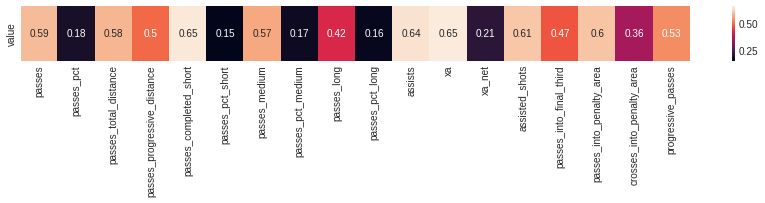

In [ ]:
# 연계
plt.figure(figsize=(15,1))
sns.heatmap(FW_under_age[passing+['value']].corr().iloc[-1:,:-1],annot = True)

In [ ]:
passing_top4 = FW_under_age[passing+['value']].corr().iloc[-1,:-1].sort_values(ascending=False).index[:4]

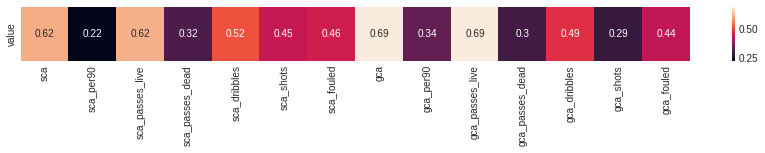

In [ ]:
# gca
plt.figure(figsize=(15,1))
sns.heatmap(FW_under_age[gca+['value']].corr().iloc[-1:,:-1],annot = True)

In [ ]:
gca_top4 =FW_under_age[gca+['value']].corr().iloc[-1,:-1].sort_values(ascending=False).index[:4]

In [ ]:
def FW_promising(df, shooting_top4, passing_top4, gca_top4):
    under_age = df[df['age']<=23]
    for cols in [shooting_top4, passing_top4, gca_top4]:
        one = under_age[cols[0]]>np.percentile(under_age[cols[0]],90)
        two = under_age[cols[1]]>np.percentile(under_age[cols[1]],90)
        three = under_age[cols[2]]>np.percentile(under_age[cols[2]],90)
        four= under_age[cols[3]]>np.percentile(under_age[cols[3]],90)
        idx = under_age[one&two&three&four].index
        df.loc[idx,'promising']=1
    return df


In [ ]:
FW_promising(FW, shooting_top4, passing_top4, gca_top4)
FW_promising(FW_test_X, shooting_top4, passing_top4, gca_top4)

,goals_per_shot_on_target,player,passes_high,touches_live_ball,passes_received,squad,age,dispossessed,passes_offsides,assisted_shots,...,sca_dribbles,carry_distance,pass_targets,cards_yellow_red,xg,passes_intercepted,crosses_into_penalty_area,corner_kicks_straight,both,promising
1,0.11,Oliver Burke,57,516,356,AlavĂ©s,22,33,1,6,...,3,2795,615,0,3.2,5,0,0,0,NaN
7,0.00,John Guidetti,5,43,35,AlavĂ©s,27,2,0,1,...,0,160,64,0,0.2,1,0,0,0,NaN
8,0.36,Joselu,388,1411,1079,AlavĂ©s,29,57,14,15,...,2,2232,1636,0,10.5,21,2,0,0,NaN
11,0.00,JosĂ© Luis RodrĂ­guez,0,8,6,AlavĂ©s,21,0,0,0,...,0,20,9,0,0.0,0,0,0,0,NaN
16,0.25,Ă‰dgar MĂ©ndez,44,314,207,AlavĂ©s,29,19,0,6,...,1,1276,328,0,0.5,2,4,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2507,0.34,Wout Weghorst,189,1139,902,Wolfsburg,26,63,1,37,...,6,2926,1581,0,15.1,21,2,0,0,NaN
2515,0.33,RaĂşl JimĂ©nez,198,1448,1150,Wolves,28,88,3,42,...,13,6584,1838,0,14.7,27,4,0,0,NaN
2517,0.27,Diogo Jota,113,1209,943,Wolves,22,72,4,32,...,16,8178,1293,0,9.6,15,6,0,0,NaN
2520,0.50,Pedro Neto,55,511,385,Wolves,19,25,1,15,...,6,3857,558,0,2.0,7,4,0,0,NaN


In [ ]:
FW['promising'].value_counts()

0    1126
1      49
Name: promising, dtype: int64

#### MF

In [ ]:
MF['promising'] = 0
MF_under_age = MF[MF['age']<=23]

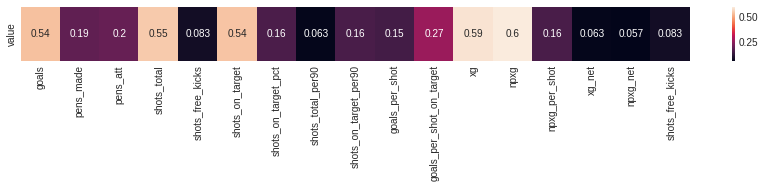

In [ ]:
# 슈팅
plt.figure(figsize=(15,1))
sns.heatmap(MF_under_age[shooting+['value']].corr().iloc[-1:,:-1],annot = True)

In [ ]:
shooting_top4 = MF_under_age[shooting+['value']].corr().iloc[-1,:-1].sort_values(ascending=False).index[:4]

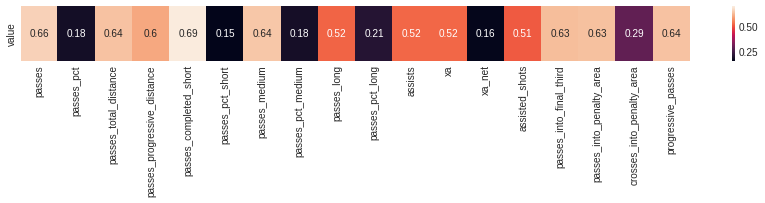

In [ ]:
# 연계
plt.figure(figsize=(15,1))
sns.heatmap(MF_under_age[passing+['value']].corr().iloc[-1:,:-1],annot = True)

In [ ]:
passing_top4 = MF_under_age[passing+['value']].corr().iloc[-1,:-1].sort_values(ascending=False).index[:4]

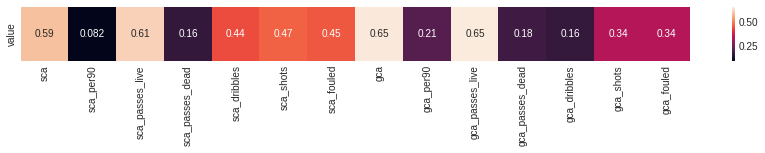

In [ ]:
# gca
plt.figure(figsize=(15,1))
sns.heatmap(MF_under_age[gca+['value']].corr().iloc[-1:,:-1],annot = True)

In [ ]:
gac_top4 =MF_under_age[gca+['value']].corr().iloc[-1,:-1].sort_values(ascending=False).index[:4]

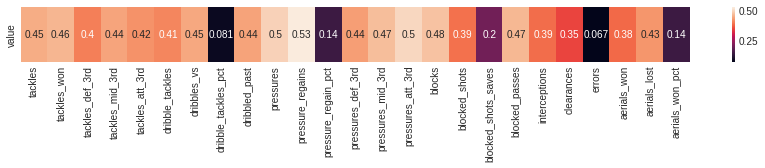

In [ ]:
# 수비
plt.figure(figsize=(15,1))
sns.heatmap(MF_under_age[defense+['value']].corr().iloc[-1:,:-1],annot = True)

In [ ]:
defense_top4=MF_under_age[defense+['value']].corr().iloc[-1,:-1].sort_values(ascending=False).index[:4]

In [ ]:
def MF_promising(df,shooting_top4, passing_top4,gac_top4,defense_top4):
    under_age = df[df['age']<=23]
    for cols in [shooting_top4, passing_top4, gac_top4, defense_top4]:
        one = under_age[cols[0]]>np.percentile(under_age[cols[0]],90)
        two = under_age[cols[1]]>np.percentile(under_age[cols[1]],90)
        three = under_age[cols[2]]>np.percentile(under_age[cols[2]],90)
        four= under_age[cols[3]]>np.percentile(under_age[cols[3]],90)
        idx = under_age[one&two&three&four].index
        df.loc[idx,'promising']=1
    return df


In [ ]:
MF_promising(MF, shooting_top4, passing_top4,gac_top4,defense_top4)
MF_promising(MF_test_X, shooting_top4, passing_top4,gac_top4,defense_top4)

,goals_per_shot_on_target,player,passes_high,touches_live_ball,passes_received,squad,age,dispossessed,passes_offsides,assisted_shots,...,blocked_shots,carry_distance,pass_targets,cards_yellow_red,xg,passes_intercepted,crosses_into_penalty_area,corner_kicks_straight,both,promising
2,0.00,VĂ­ctor Camarasa,97,624,432,AlavĂ©s,25,12,1,14,...,3,2401,512,0,0.3,8,2,1,0,NaN
5,0.00,Ljubomir Fejsa,61,355,178,AlavĂ©s,30,3,1,1,...,1,685,196,0,0.0,4,0,0,0,NaN
6,0.00,Manu GarcĂ­a,177,951,532,AlavĂ©s,33,25,2,2,...,10,2144,655,1,2.0,6,0,0,0,NaN
13,0.00,Abdallahi Mahmoud,1,61,35,AlavĂ©s,19,2,0,0,...,0,211,36,0,0.0,0,0,0,0,NaN
20,1.00,TomĂˇs Pina Isla,96,662,361,AlavĂ©s,31,9,2,4,...,5,1605,401,1,0.9,9,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2512,0.80,Leander Dendoncker,198,1583,1011,Wolves,24,16,4,7,...,13,4350,1186,0,1.6,20,1,0,0,NaN
2514,0.00,Morgan Gibbs-White,16,97,80,Wolves,19,1,1,3,...,0,459,99,0,0.1,1,1,0,0,NaN
2516,0.00,Bruno JordĂŁo,1,6,3,Wolves,20,0,0,0,...,0,39,3,0,0.0,0,0,0,0,NaN
2519,0.17,JoĂŁo Moutinho,603,1973,1374,Wolves,32,20,4,80,...,14,6151,1512,0,0.8,27,12,12,0,NaN


In [ ]:
MF['promising'].value_counts()

0    1121
1      67
Name: promising, dtype: int64

#### DF

In [ ]:
DF['promising'] = 0
DF_under_age = DF[DF['age']<=23]

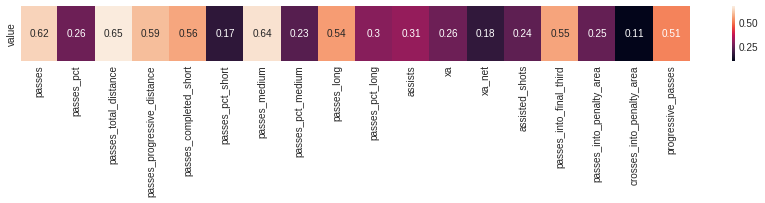

In [ ]:
# 연계
plt.figure(figsize=(15,1))
sns.heatmap(DF_under_age[passing+['value']].corr().iloc[-1:,:-1],annot = True)

In [ ]:
passing_top4 = DF_under_age[passing+['value']].corr().iloc[-1,:-1].sort_values(ascending=False).index[:4]

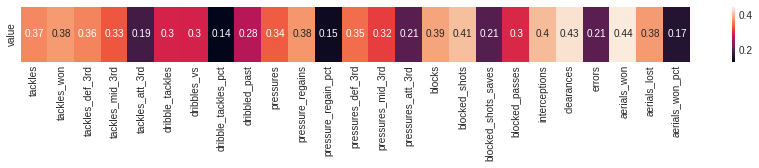

In [ ]:
# gca
plt.figure(figsize=(15,1))
sns.heatmap(DF_under_age[defense+['value']].corr().iloc[-1:,:-1],annot = True)

In [ ]:
defense_top4=DF_under_age[defense+['value']].corr().iloc[-1,:-1].sort_values(ascending=False).index[:4]

In [ ]:
def DF_promising(df, passing_top4, defense_top4):
    under_age = df[df['age']<=23]
    for cols in [passing_top4, defense_top4]:
        one = under_age[cols[0]]>np.percentile(under_age[cols[0]],90)
        two = under_age[cols[1]]>np.percentile(under_age[cols[1]],90)
        three = under_age[cols[2]]>np.percentile(under_age[cols[2]],90)
        four= under_age[cols[3]]>np.percentile(under_age[cols[3]],90)
        idx = under_age[one&two&three&four].index
        df.loc[idx,'promising']=1
    return df


In [ ]:
DF_promising(DF, passing_top4, defense_top4)
DF_promising(DF_test_X, passing_top4, defense_top4)

,player,passes_high,touches_live_ball,passes_received,squad,age,dispossessed,passes_offsides,assisted_shots,crosses,...,tackles_att_3rd,passes_right_foot,blocked_shots,carry_distance,pass_targets,cards_yellow_red,passes_intercepted,crosses_into_penalty_area,corner_kicks_straight,promising
0,Martin Aguirregabiria,296,986,608,AlavĂ©s,23,17,3,12,30,...,5,661,8,3313,677,0,17,5,0,NaN
3,RubĂ©n Duarte,495,1323,730,AlavĂ©s,23,16,3,11,44,...,5,116,9,3688,791,0,18,8,0,NaN
4,Rodrigo Ely,265,1075,544,AlavĂ©s,25,8,0,1,0,...,0,588,20,2576,569,0,4,0,0,NaN
9,VĂ­ctor Laguardia,405,1257,675,AlavĂ©s,29,3,3,7,4,...,0,811,16,3139,692,0,7,1,0,NaN
10,Javi LĂłpez,10,37,17,AlavĂ©s,17,1,0,0,2,...,0,1,1,107,19,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2511,Conor Coady,515,2012,1352,Wolves,26,2,3,5,0,...,0,1584,18,6932,1357,0,15,0,0,NaN
2513,Matt Doherty,426,1823,1319,Wolves,27,23,3,23,38,...,4,1180,5,6276,1542,0,35,9,0,NaN
2518,Max Kilman,14,118,74,Wolves,22,0,2,0,0,...,0,6,1,302,77,0,1,0,0,NaN
2524,Romain SaĂŻss,362,1891,1165,Wolves,29,8,4,7,7,...,0,136,19,4699,1201,1,18,0,0,NaN


In [ ]:
DF['promising'].value_counts()

0    1390
1      32
Name: promising, dtype: int64

#### GK

In [ ]:
GK['promising'] = 0
GK_test_X['promising'] = 0
GK_under_age = GK[GK['age']<=23]

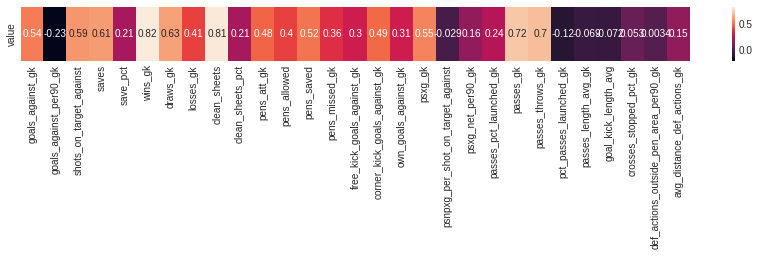

In [ ]:
# 골키핑
plt.figure(figsize=(15,1))
sns.heatmap(GK_under_age[keeper+['value']].corr().iloc[-1:,:-1],annot = True)

In [ ]:
keeper_top4 = GK_under_age[keeper+['value']].corr().iloc[-1,:-1].sort_values(ascending=False).index[:4]

In [ ]:
def GK_promising(df, keeper_top4):
    under_age = df[df['age']<=23]
    for cols in [keeper_top4]:
        one = under_age[cols[0]]>np.percentile(under_age[cols[0]],90)
        two = under_age[cols[1]]>np.percentile(under_age[cols[1]],90)
        three = under_age[cols[2]]>np.percentile(under_age[cols[2]],90)
        four= under_age[cols[3]]>np.percentile(under_age[cols[3]],90)
        idx = under_age[one&two&three&four].index
        df.loc[idx,'promising']=1
    return df


In [ ]:
GK_promising(GK, keeper_top4)
GK_promising(GK_test_X, keeper_top4)

,goal_kick_length_avg,losses_gk,saves,psxg_gk,games_starts,player,avg_distance_def_actions_gk,cards_red,games,passes_left_foot,...,pens_saved,free_kick_goals_against_gk,wins_gk,pens_allowed,cards_yellow_red,potential,pens_att_gk,shots_on_target_against,Season,promising
18,61.0,13,61,33.7,27,Fernando Pacheco,13.4,1,27,509,...,3,3,7,8,0,8,11,92,20,0
23,66.0,6,36,16.2,8,Roberto,13.1,0,9,4,...,0,1,0,1,0,7,1,51,20,0
25,63.4,1,2,2.4,3,Antonio Sivera,12.8,0,3,6,...,0,0,1,1,0,8,1,4,20,0
42,55.4,13,92,41.1,28,RĂ©gis Gurtner,13.7,0,28,22,...,0,1,4,1,0,7,1,140,20,0
59,52.5,10,50,24.4,26,Ludovic Butelle,14.9,0,26,322,...,0,1,10,3,0,7,3,78,20,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2472,65.4,2,14,7.8,4,David Martin,9.0,0,5,1,...,0,0,2,0,0,7,0,20,20,0
2477,66.0,1,5,4.5,2,Darren Randolph,13.6,0,2,0,...,0,0,0,1,0,7,1,9,20,0
2488,48.7,9,69,36.8,26,Koen Casteels,15.5,0,26,649,...,0,1,11,4,0,8,4,104,20,0
2500,46.2,2,29,9.2,8,Pavao Pervan,15.0,0,8,17,...,0,0,2,1,0,7,1,36,20,0


In [ ]:
GK['promising'].value_counts()

0    333
1      2
Name: promising, dtype: int64

# Part2. 모델링

## 2-1.basemodel

### 모델링에 사용할 변수 선택 및 포지션별 X,y 분리

In [ ]:
ALL= ['squad', 'age', 'international_reputation', 'potential','Season','promising', 'games_starts', 'minutes']
FW_MF_ALL = ['both']

In [ ]:
FW_features = list(FW[shooting+gca+passing+[target]].corr().iloc[-1,:-1].sort_values(ascending=False).index[:20])
MF_features = list(MF[shooting+gca+passing+defense+[target]].corr().iloc[-1,:-1].sort_values(ascending=False).index[:20])
DF_features = list(DF[passing+defense+[target]].corr().iloc[-1,:-1].sort_values(ascending=False).index[:20])
# 필드플레이어에 비해 데이터 수가 적어서 10개만 선정
GK_features = list(GK[keeper+[target]].corr().iloc[-1,:-1].sort_values(ascending=False).index[:10])

In [ ]:
FW_X = FW.drop(target, axis=1)[(FW_features+ALL+FW_MF_ALL)]
FW_y = FW[target]

MF_X = MF.drop(target, axis=1)[MF_features+ALL+FW_MF_ALL]
MF_y = MF[target]

DF_X = DF.drop(target, axis=1)[ALL+DF_features]
DF_y = DF[target]

GK_X = GK.drop(target, axis=1)[ALL+GK_features]
GK_y = GK[target]

In [ ]:
FW_train_X,FW_val_X, FW_train_y,FW_val_y = train_test_split(FW_X,FW_y ,test_size=0.3)
MF_train_X,MF_val_X, MF_train_y,MF_val_y = train_test_split(MF_X,MF_y ,test_size=0.3)
DF_train_X,DF_val_X, DF_train_y,DF_val_y = train_test_split(DF_X,DF_y ,test_size=0.3)
GK_train_X,GK_val_X, GK_train_y,GK_val_y = train_test_split(GK_X,GK_y ,test_size=0.3)

print('FW (훈련 데이터셋,검정데이터셋 크기)', (FW_train_X.shape, FW_val_X.shape))
print('MF (훈련 데이터셋,검정데이터셋 크기)', (MF_train_X.shape, MF_val_X.shape))
print('DF (훈련 데이터셋,검정데이터셋 크기)', (DF_train_X.shape, DF_val_X.shape))
print('GK (훈련 데이터셋,검정데이터셋 크기)', (GK_train_X.shape, GK_val_X.shape))

FW (훈련 데이터셋,검정데이터셋 크기) ((822, 29), (353, 29))
MF (훈련 데이터셋,검정데이터셋 크기) ((831, 29), (357, 29))
DF (훈련 데이터셋,검정데이터셋 크기) ((995, 28), (427, 28))
GK (훈련 데이터셋,검정데이터셋 크기) ((234, 18), (101, 18))


### Baseline model 생성후 평가

#### Baseline model 
train 데이터의 평균으로 설정

In [ ]:
FW_baseline = FW_train_y.mean()
MF_baseline = MF_train_y.mean()
DF_baseline = DF_train_y.mean()
GK_baseline = GK_train_y.mean()

#### metric 설정

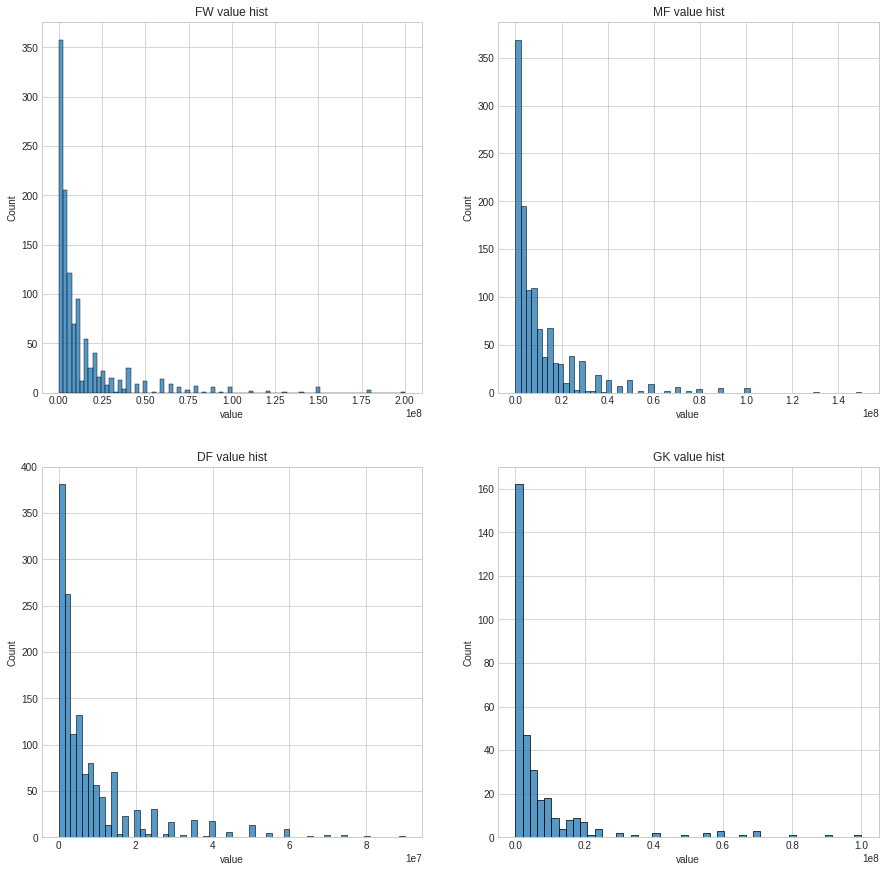

In [ ]:
plt.figure(figsize=(15,15))
plt.subplot(221)
plt.title('FW value hist')
sns.histplot(FW_y)

plt.subplot(222)
plt.title('MF value hist')
sns.histplot(MF_y)

plt.subplot(223)
plt.title('DF value hist')
sns.histplot(DF_y)

plt.subplot(224)
plt.title('GK value hist')
sns.histplot(GK_y)

몇몇 소수의 스타플레이어들이 일반적인 선수들에 비해 높은 value를 갖는다. 

-> loss 함수는 이상치에 상대적으로 덜 민감한 mean absolute error를 사용

#### baseline 모델 성능 확인

In [ ]:
FW_base_mae = mean_absolute_error(FW_val_y,[FW_baseline] * len(FW_val_y))
MF_base_mae = mean_absolute_error(MF_val_y,[MF_baseline] * len(MF_val_y))
DF_base_mae = mean_absolute_error(DF_val_y,[DF_baseline] * len(DF_val_y))
GK_base_mae = mean_absolute_error(GK_val_y,[GK_baseline] * len(GK_val_y))
FW_base_R2 = r2_score(FW_val_y,[FW_baseline] * len(FW_val_y))
MF_base_R2 = r2_score(MF_val_y,[MF_baseline] * len(MF_val_y))
DF_base_R2 = r2_score(DF_val_y,[DF_baseline] * len(DF_val_y))
GK_base_R2 = r2_score(GK_val_y,[GK_baseline] * len(GK_val_y))

In [ ]:
print('FW baseline model val MAE:', FW_base_mae)
print('MF baseline model val MAE:', MF_base_mae)
print('DF baseline model val MAE:', DF_base_mae)
print('GK baseline model val MAE:', GK_base_mae)
print('-'*50)
print('FW baseline model val R2:', FW_base_R2)
print('MF baseline model val R2:', MF_base_R2)
print('DF baseline model val R2:', DF_base_R2)
print('GK baseline model val R2:', GK_base_R2)

FW baseline model val MAE: 14070699.754623216
MF baseline model val MAE: 10249926.0871617
DF baseline model val MAE: 7776105.9866075115
GK baseline model val MAE: 8935985.021579083
--------------------------------------------------
FW baseline model val R2: -0.001599456395996901
MF baseline model val R2: -0.001344919729943772
DF baseline model val R2: -0.0016391730016820372
GK baseline model val R2: -1.801834487791254e-05


## 2-2. 모델링

Target : value -> 선수의 가치를 나타내는 연속형 변수

- 회귀모델로 모델링 실시

metric을 정할때 target값들이 right-skewed 된 것을 확인했다.

-> 로그를 취해주어 분포를 조정해주자.

In [ ]:
FW_train_y, FW_val_y = np.log1p(FW_train_y), np.log1p(FW_val_y)
MF_train_y, MF_val_y = np.log1p(MF_train_y), np.log1p(MF_val_y)
DF_train_y, DF_val_y = np.log1p(DF_train_y), np.log1p(DF_val_y)
GK_train_y, GK_val_y = np.log1p(GK_train_y), np.log1p(GK_val_y)

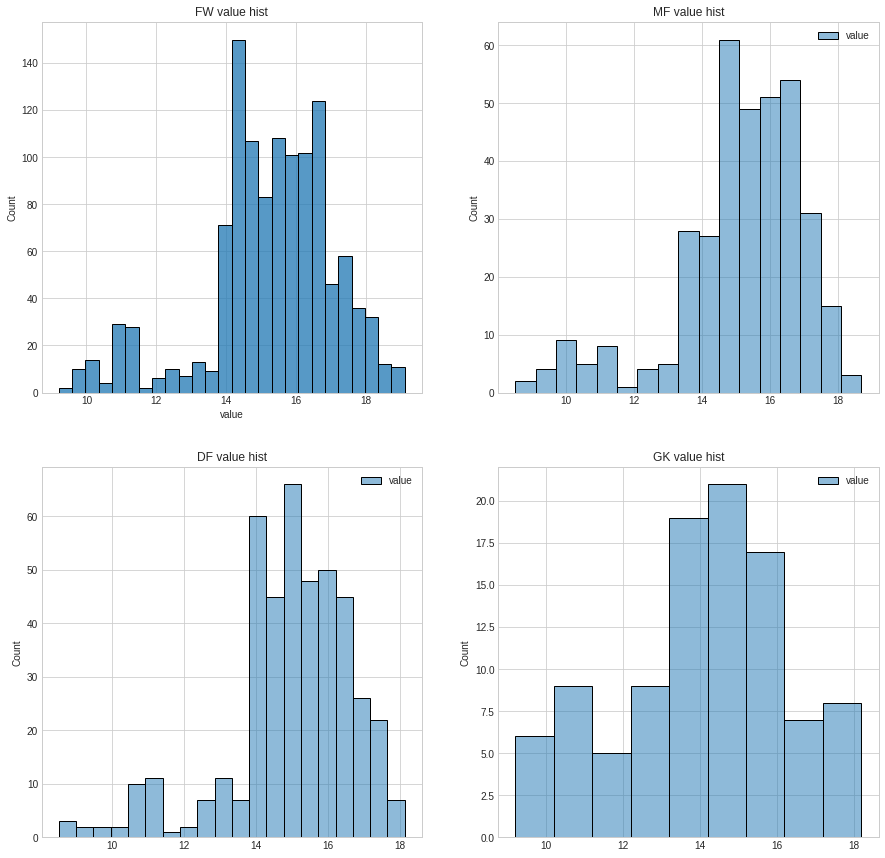

In [ ]:
plt.figure(figsize=(15,15))
plt.subplot(221)
plt.title('FW value hist')
sns.histplot(pd.concat([FW_train_y,FW_val_y]))

plt.subplot(222)
plt.title('MF value hist')
sns.histplot([MF_train_y,MF_val_y])

plt.subplot(223)
plt.title('DF value hist')
sns.histplot([DF_train_y,DF_val_y])

plt.subplot(224)
plt.title('GK value hist')
sns.histplot([GK_train_y,GK_val_y])

In [ ]:
def get_model_mae(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1:
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    return mean_absolute_error(y_test, pred)

In [ ]:
def get_model_r2(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1:
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    return r2_score(y_test, pred)

In [ ]:
RF = make_pipeline(
     OrdinalEncoder(cols='squad'),
     RandomForestRegressor(random_state=2022)
)
EX = make_pipeline(
     OrdinalEncoder(cols='squad'),
     ExtraTreesRegressor(random_state=2022)
)
ADA = make_pipeline(
     OrdinalEncoder(cols='squad'),
     AdaBoostRegressor(random_state=2022)
)
XGB = make_pipeline(
     OrdinalEncoder(cols='squad'),
     XGBRegressor(random_state=2022,verbose=0)
)
LGB = make_pipeline(
     OrdinalEncoder(cols='squad'),
     LGBMRegressor(random_state=2022,verbose=0)
)

CAT = make_pipeline(
     OrdinalEncoder(cols='squad'),
     CatBoostRegressor(random_state=2022,verbose=0)
)

In [ ]:
model_name = ['baseline']
mae_list = [FW_base_mae]
r2_list = [FW_base_R2]
for model in [RF,EX,ADA,XGB,LGB,CAT]:
    model_name.append(model.steps[1][0])
    mae_list.append(get_model_mae(model, FW_train_X, FW_val_X, FW_train_y, FW_val_y, is_expm1=True))
    r2_list.append(get_model_r2(model, FW_train_X, FW_val_X, FW_train_y, FW_val_y, is_expm1=True))


[10:56:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:56:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


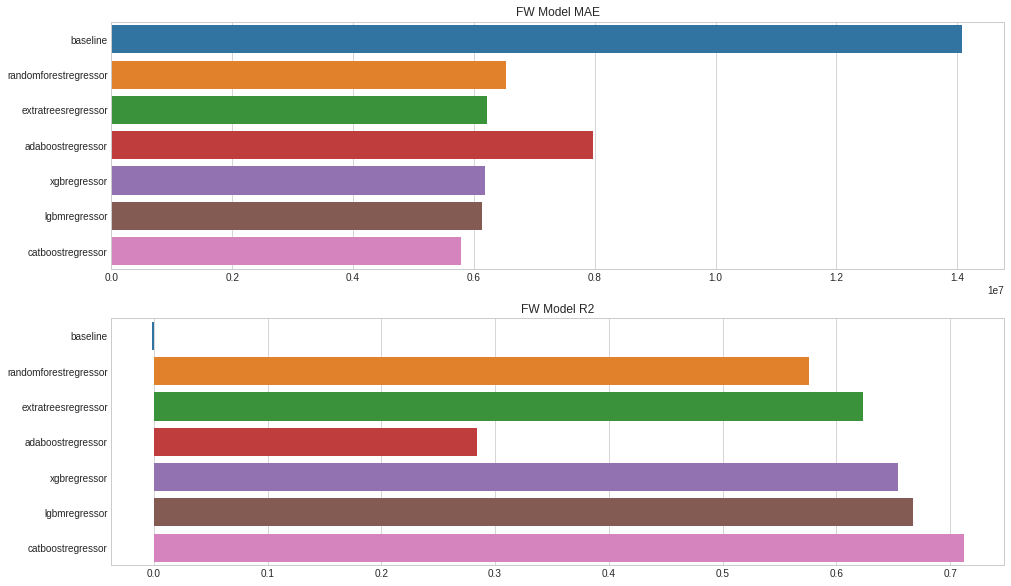

In [ ]:
plt.figure(figsize=(16,10))
plt.subplot(211)
plt.title('FW Model MAE')
sns.barplot(y=model_name, x=mae_list)
plt.subplot(212)
plt.title('FW Model R2')
sns.barplot(y=model_name, x=r2_list)

catboost가 $R^2$가 가장 높고 MAE값이 가장 낮다. 

In [ ]:
model_name = ['baseline']
mae_list = [MF_base_mae]
r2_list = [MF_base_R2]
for model in [RF,EX,ADA,XGB,LGB,CAT]:
    model_name.append(model.steps[1][0])
    mae_list.append(get_model_mae(model, MF_train_X, MF_val_X, MF_train_y, MF_val_y, is_expm1=True))
    r2_list.append(get_model_r2(model, MF_train_X, MF_val_X, MF_train_y, MF_val_y, is_expm1=True))


[10:56:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:56:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


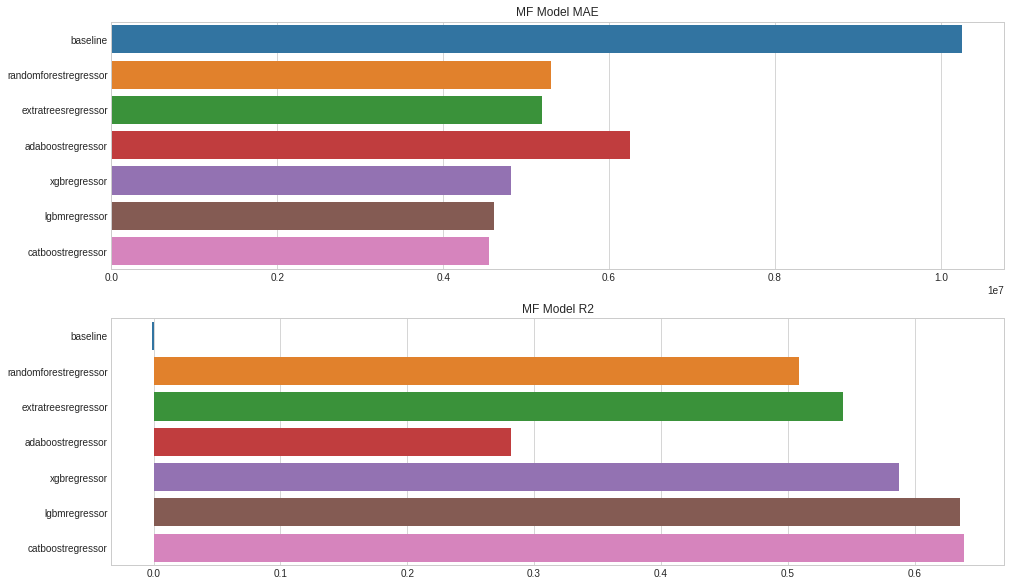

In [ ]:
plt.figure(figsize=(16,10))
plt.subplot(211)
plt.title('MF Model MAE')
sns.barplot(y=model_name, x=mae_list)
plt.subplot(212)
plt.title('MF Model R2')
sns.barplot(y=model_name, x=r2_list)

이번에도 역시 catboost가 $R^2$가 가장 높고 MAE값이 가장 낮다. 

In [ ]:
model_name = ['baseline']
mae_list = [DF_base_mae]
r2_list = [DF_base_R2]
for model in [RF,EX,ADA,XGB,LGB,CAT]:
    model_name.append(model.steps[1][0])
    mae_list.append(get_model_mae(model, DF_train_X, DF_val_X, DF_train_y, DF_val_y, is_expm1=True))
    r2_list.append(get_model_r2(model, DF_train_X, DF_val_X, DF_train_y, DF_val_y, is_expm1=True))


[10:56:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:56:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


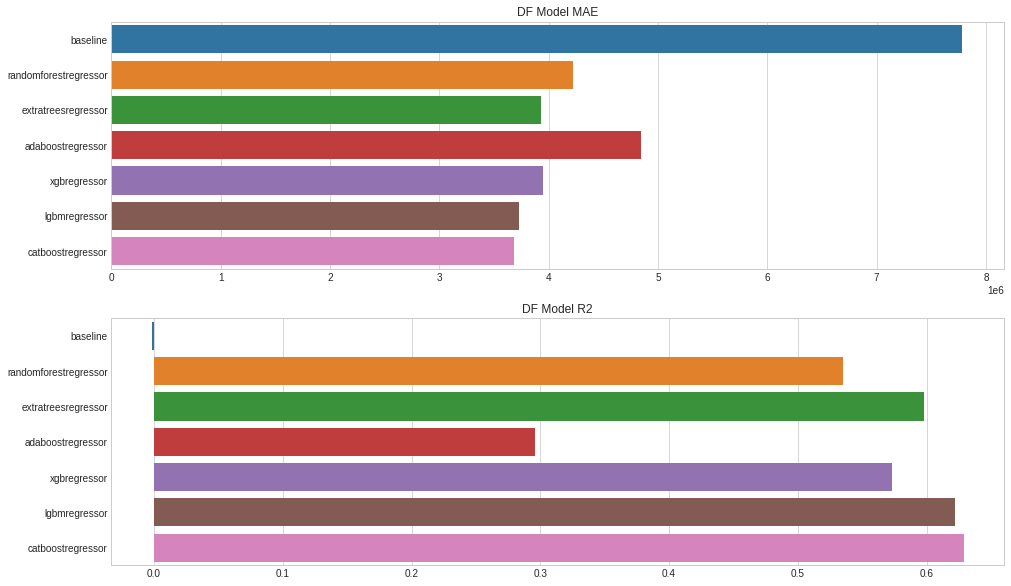

In [ ]:
plt.figure(figsize=(16,10))
plt.subplot(211)
plt.title('DF Model MAE')
sns.barplot(y=model_name, x=mae_list)
plt.subplot(212)
plt.title('DF Model R2')
sns.barplot(y=model_name, x=r2_list)

DF 역시 catboost가 $R^2$가 가장 높고 MAE값이 가장 낮다. 

In [ ]:
model_name = ['baseline']
mae_list = [GK_base_mae]
r2_list = [GK_base_R2]
for model in [RF,EX,ADA,XGB,LGB,CAT]:
    model_name.append(model.steps[1][0])
    mae_list.append(get_model_mae(model, GK_train_X, GK_val_X, GK_train_y, GK_val_y, is_expm1=True))
    r2_list.append(get_model_r2(model, GK_train_X, GK_val_X, GK_train_y, GK_val_y, is_expm1=True))

[10:56:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:56:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


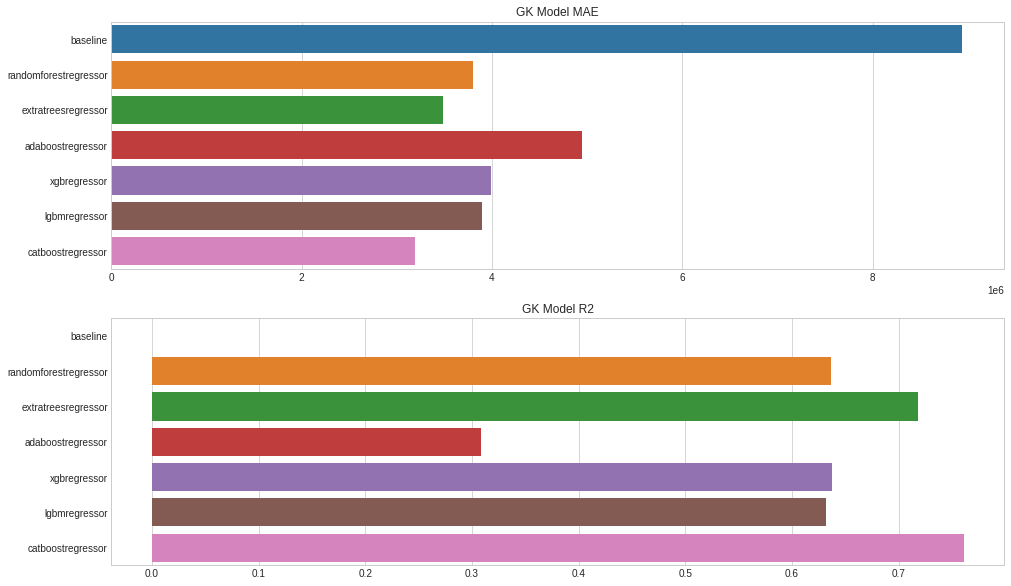

In [ ]:
plt.figure(figsize=(16,10))
plt.subplot(211)
plt.title('GK Model MAE')
sns.barplot(y=model_name, x=mae_list)
plt.subplot(212)
plt.title('GK Model R2')
sns.barplot(y=model_name, x=r2_list)

extra 와 catboost가 가장 성능이 좋아보인다. -> 통일을 위해 catboost사용

#### 모델 결정
- 필드플레이어 : CatBoost
- 골키퍼 : RandomForest

In [ ]:
params = {'transformedtargetregressor__regressor__learning_rate': [0.03, 0.1],
        'transformedtargetregressor__regressor__depth': [2, 4, 6, 8],
        'transformedtargetregressor__regressor__l2_leaf_reg': [0.2, 0.5, 1, 3]}


CAT = CatBoostRegressor(random_state=2022, n_estimators=200, verbose=0, task_type="GPU", devices='0:1')
pipe = make_pipeline(
     OrdinalEncoder(cols='squad'),
     TransformedTargetRegressor(
    regressor=CAT, func=np.log1p, inverse_func=np.expm1
)
)

grid_search = GridSearchCV(pipe, param_grid=params,scoring='neg_mean_absolute_error', cv=5, verbose=0)
grid_search.fit(FW_X, FW_y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder',
                                        OrdinalEncoder(cols='squad')),
                                       ('transformedtargetregressor',
                                        TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                                   inverse_func=<ufunc 'expm1'>,
                                                                   regressor=<catboost.core.CatBoostRegressor object at 0x7ff9a8d48fd0>))]),
             param_grid={'transformedtargetregressor__regressor__depth': [2, 4,
                                                                          6,
                                                                          8],
                         'transformedtargetregressor__regressor__l2_leaf_reg': [0.2,
                                                                                0.5,
                                                  

In [ ]:
print("최적 하이퍼파라미터: ", grid_search.best_params_)
print("최적 MAE: ", -grid_search.best_score_)

최적 하이퍼파라미터:  {'transformedtargetregressor__regressor__depth': 6, 'transformedtargetregressor__regressor__l2_leaf_reg': 0.2, 'transformedtargetregressor__regressor__learning_rate': 0.1}
최적 MAE:  5795135.590570367


In [ ]:
FW_best_model = grid_search.best_estimator_

In [ ]:
grid_params=grid_search.cv_results_['params']
grid_score=grid_search.cv_results_['mean_test_score']

In [ ]:
score_df = pd.DataFrame({'params':grid_params, 'mean_test_score':-grid_score}).sort_values(by='mean_test_score').reset_index(drop=True)

In [ ]:
for param in score_df.loc[:5,'params']:
    print(param)

{'transformedtargetregressor__regressor__depth': 6, 'transformedtargetregressor__regressor__l2_leaf_reg': 0.2, 'transformedtargetregressor__regressor__learning_rate': 0.1}
{'transformedtargetregressor__regressor__depth': 4, 'transformedtargetregressor__regressor__l2_leaf_reg': 0.2, 'transformedtargetregressor__regressor__learning_rate': 0.1}
{'transformedtargetregressor__regressor__depth': 6, 'transformedtargetregressor__regressor__l2_leaf_reg': 0.5, 'transformedtargetregressor__regressor__learning_rate': 0.1}
{'transformedtargetregressor__regressor__depth': 4, 'transformedtargetregressor__regressor__l2_leaf_reg': 0.5, 'transformedtargetregressor__regressor__learning_rate': 0.1}
{'transformedtargetregressor__regressor__depth': 6, 'transformedtargetregressor__regressor__l2_leaf_reg': 3, 'transformedtargetregressor__regressor__learning_rate': 0.1}
{'transformedtargetregressor__regressor__depth': 6, 'transformedtargetregressor__regressor__l2_leaf_reg': 1, 'transformedtargetregressor__regr

for 시간 단축: MF,DF,GK 모델링에 있어서는 depth는 4,6인 모델이 우수한 성능을 보였기 때문에 4,6만 그리드 서치를 돌려준다.

In [ ]:
params = {'transformedtargetregressor__regressor__learning_rate': [0.03, 0.1],
          'transformedtargetregressor__regressor__depth': [4, 6],
        'transformedtargetregressor__regressor__l2_leaf_reg': [0.2, 0.5, 1, 3]}

CAT = CatBoostRegressor(random_state=2022, n_estimators=200, verbose=0, task_type="GPU", devices='0:1')
pipe = make_pipeline(
     OrdinalEncoder(cols='squad'),
     TransformedTargetRegressor(
    regressor=CAT, func=np.log1p, inverse_func=np.expm1
)
)

grid_search = GridSearchCV(pipe, param_grid=params,scoring='neg_mean_absolute_error', cv=5, verbose=0)
grid_search.fit(MF_X, MF_y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder',
                                        OrdinalEncoder(cols='squad')),
                                       ('transformedtargetregressor',
                                        TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                                   inverse_func=<ufunc 'expm1'>,
                                                                   regressor=<catboost.core.CatBoostRegressor object at 0x7ff9a8cbb790>))]),
             param_grid={'transformedtargetregressor__regressor__depth': [4, 6],
                         'transformedtargetregressor__regressor__l2_leaf_reg': [0.2,
                                                                                0.5,
                                                                                1,
                                                                                3],
                         'transformed

In [ ]:
print("최적 하이퍼파라미터: ", grid_search.best_params_)
print("최적 MAE: ", -grid_search.best_score_)

최적 하이퍼파라미터:  {'transformedtargetregressor__regressor__depth': 6, 'transformedtargetregressor__regressor__l2_leaf_reg': 3, 'transformedtargetregressor__regressor__learning_rate': 0.1}
최적 MAE:  4781249.178071336


In [ ]:
MF_best_model = grid_search.best_estimator_

In [ ]:
CAT = CatBoostRegressor(random_state=2022, n_estimators=200, depth =6, verbose=0, task_type="GPU", devices='0:1')
pipe = make_pipeline(
     OrdinalEncoder(cols='squad'),
     TransformedTargetRegressor(
    regressor=CAT, func=np.log1p, inverse_func=np.expm1
)
)

grid_search = GridSearchCV(pipe, param_grid=params,scoring='neg_mean_absolute_error', cv=5, verbose=0)
grid_search.fit(DF_X, DF_y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder',
                                        OrdinalEncoder(cols='squad')),
                                       ('transformedtargetregressor',
                                        TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                                   inverse_func=<ufunc 'expm1'>,
                                                                   regressor=<catboost.core.CatBoostRegressor object at 0x7ff9a8d17f50>))]),
             param_grid={'transformedtargetregressor__regressor__depth': [4, 6],
                         'transformedtargetregressor__regressor__l2_leaf_reg': [0.2,
                                                                                0.5,
                                                                                1,
                                                                                3],
                         'transformed

In [ ]:
print("최적 하이퍼파라미터: ", grid_search.best_params_)
print("최적 MAE: ", -grid_search.best_score_)

최적 하이퍼파라미터:  {'transformedtargetregressor__regressor__depth': 4, 'transformedtargetregressor__regressor__l2_leaf_reg': 0.2, 'transformedtargetregressor__regressor__learning_rate': 0.1}
최적 MAE:  4188187.231240675


In [ ]:
DF_best_model = grid_search.best_estimator_

In [ ]:
CAT = CatBoostRegressor(random_state=2022, n_estimators=200, depth =6, verbose=0, task_type="GPU", devices='0:1')
pipe = make_pipeline(
     OrdinalEncoder(cols='squad'),
     TransformedTargetRegressor(
    regressor=CAT, func=np.log1p, inverse_func=np.expm1
)
)


grid_search = GridSearchCV(pipe, param_grid=params,scoring='neg_mean_absolute_error', cv=5, verbose=1)
grid_search.fit(GK_X, GK_y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder',
                                        OrdinalEncoder(cols='squad')),
                                       ('transformedtargetregressor',
                                        TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                                   inverse_func=<ufunc 'expm1'>,
                                                                   regressor=<catboost.core.CatBoostRegressor object at 0x7ff9a8cbbed0>))]),
             param_grid={'transformedtargetregressor__regressor__depth': [4, 6],
                         'transformedtargetregressor__regressor__l2_leaf_reg': [0.2,
                                                                                0.5,
                                                                                1,
                                                                                3],
                         'transformed

In [ ]:
print("최적 하이퍼파라미터: ", grid_search.best_params_)
print("최적 MAE: ", -grid_search.best_score_)

최적 하이퍼파라미터:  {'transformedtargetregressor__regressor__depth': 4, 'transformedtargetregressor__regressor__l2_leaf_reg': 1, 'transformedtargetregressor__regressor__learning_rate': 0.1}
최적 MAE:  3384575.4772021757


In [ ]:
GK_best_model = grid_search.best_estimator_

### 일반화 성능 평가

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

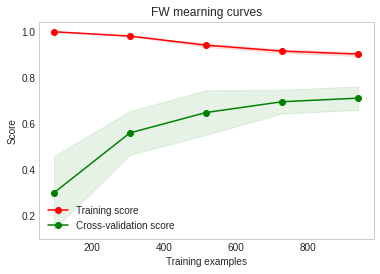

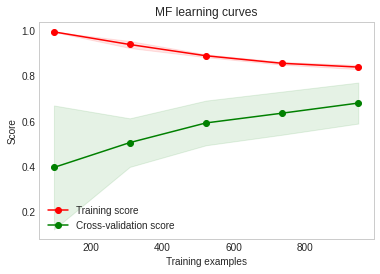

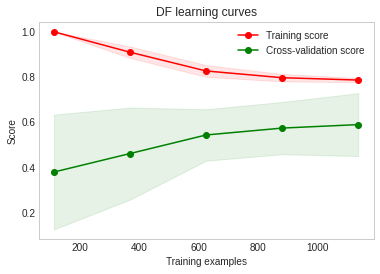

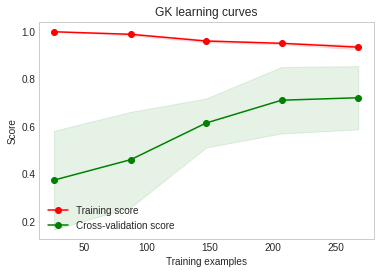

In [ ]:
g = plot_learning_curve(FW_best_model,"FW mearning curves", FW_X, FW_y, cv=5)
g = plot_learning_curve(MF_best_model,"MF learning curves",MF_X, MF_y, cv=5)
g = plot_learning_curve(DF_best_model,"DF learning curves",DF_X, DF_y, cv=5)
g = plot_learning_curve(GK_best_model,"GK learning curves",GK_X, GK_y ,cv=5)


boosting model이라 과대적합 경향이 심하긴 하지만 training examples이 증가하면서 cross validation score가 계속증가하고 train score는 낮아지는 것으로 보아 학습이 잘 이루어지고 있는 것을 확인 가능하다.

## 2-3 19/20 년 기록을 바탕으로 선수 가치 예측

In [ ]:
FW_test_X_pre = FW_test_X[FW_features+ALL+FW_MF_ALL]
MF_test_X_pre = MF_test_X[MF_features+ALL+FW_MF_ALL]
DF_test_X_pre = DF_test_X[ALL+DF_features]
GK_test_X_pre = GK_test_X[ALL+GK_features]

In [ ]:
FW_pred = FW_best_model.predict(FW_test_X_pre)
MF_pred = MF_best_model.predict(MF_test_X_pre)
DF_pred = DF_best_model.predict(DF_test_X_pre)
GK_pred = GK_best_model.predict(GK_test_X_pre)

In [ ]:
FW_test_y = df20.loc[df20['position']=='FW',target]
MF_test_y = df20.loc[df20['position']=='MF',target]
DF_test_y = df20.loc[df20['position']=='DF',target]
GK_test_y = df20.loc[df20['position']=='GK',target]

In [ ]:
FW_test_mae = mean_absolute_error(FW_test_y, FW_pred)
MF_test_mae = mean_absolute_error(MF_test_y, MF_pred)
DF_test_mae = mean_absolute_error(DF_test_y, DF_pred)
GK_test_mae = mean_absolute_error(GK_test_y, GK_pred)
FW_test_r2 = r2_score(FW_test_y, FW_pred)
MF_test_r2 = r2_score(MF_test_y, MF_pred)
DF_test_r2 = r2_score(DF_test_y, DF_pred)
GK_test_r2 = r2_score(GK_test_y, GK_pred)
print('FW MAE:', FW_test_mae)
print('MF MAE:', MF_test_mae)
print('DF MAE:', DF_test_mae)
print('GK MAE:', GK_test_mae)

print('FW R2(Score):', FW_test_r2)
print('MF R2(Score):', MF_test_r2)
print('DF R2(Score):', DF_test_r2)
print('GK R2(Score):', GK_test_r2)

FW MAE: 5504631.8956563
MF MAE: 4446766.449606158
DF MAE: 4285431.525538654
GK MAE: 3119288.664470241
FW R2(Score): 0.6913954119327821
MF R2(Score): 0.7080777916403336
DF R2(Score): 0.5994546819369273
GK R2(Score): 0.8148244631404328


In [ ]:
FW_test_X = test_X.loc[test_X['position']=='FW',FW_col]
MF_test_X = test_X.loc[test_X['position']=='MF',MF_col]
DF_test_X = test_X.loc[test_X['position']=='DF',DF_col]
GK_test_X = test_X.loc[test_X['position']=='GK',GK_col]

In [ ]:
FW_test_X['value'] = FW_pred
MF_test_X['value'] = MF_pred
DF_test_X['value'] = DF_pred
GK_test_X['value'] = GK_pred

In [ ]:
FW_test_X.to_csv('FW.csv')
MF_test_X.to_csv('MF.csv')
DF_test_X.to_csv('DF.csv')
GK_test_X.to_csv('GK.csv')

## 2-4 모델 해석

### FW

#### 특성 중요도

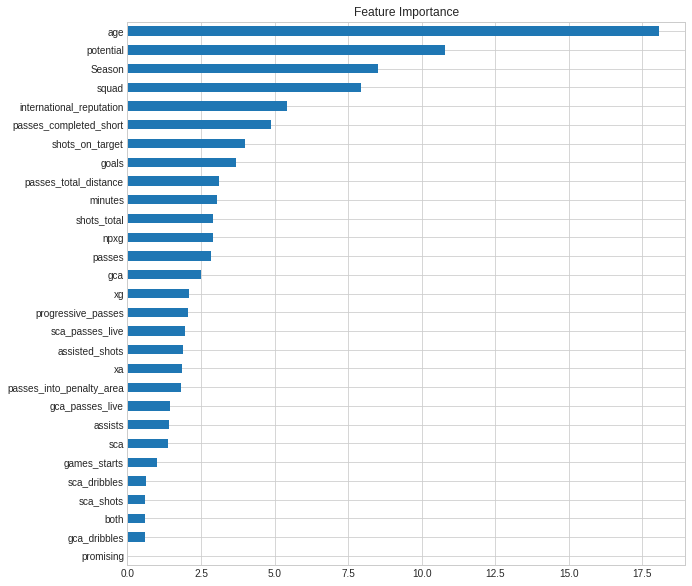

In [ ]:
plt.figure(figsize=(10,10))
FW_FI = FW_best_model.named_steps["transformedtargetregressor"].regressor_
importances = pd.Series(FW_FI.feature_importances_, FW_X.columns)
importances.sort_values().plot.barh()
plt.title("Feature Importance")
plt.show()

age, potentil Season, squad, international_reputation 분리시 중요하다고 판단된다.

- age의 경우 수치형 변수고 squad의 경우 카디널리티가 높아서 그럴수 있다.
- 추가해준 international_reputation과 potential은 도움이 되는 변수라 정말 다행이다.
- 그 후에는 쭉 shotting과 경기수에 대한 feature들로 구성된다.
- 그러다 마지막으로 오면 내가 야심차게 준비한 양발 변수와 유망주변수가 있다. 너무 소수가 존재해서 그럴까 중요해 보이지 않는다. 


#### PDP plot
- shots_on_target과 passes_completed_short 변수를 살펴볼 것이다.

In [ ]:
!pip3 install pdpbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 34.0 MB 1.3 MB/s 
     |████████████████████████████████| 13.1 MB 49.8 MB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758224 sha256=2247bcefd208152e2a3bc64f2fd6150be86538d8542da0cab87c7b25b36f3dd9
  Stored in directory: /root/.cache/pip/wheels/f4/d0/1a/b80035625c53131f52906a6fc4dd690d8efd2bf8af6a4015eb
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=51890888094252f67158fbfc0fbfbb064a018b004a5072fb5b2038459d08478f
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built pdpbox sklearn
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


(<Figure size 1080x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff5a9636cd0>,
  'pdp_ax': {'_pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff5a9106450>,
   '_count_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff5a90b8d50>}})

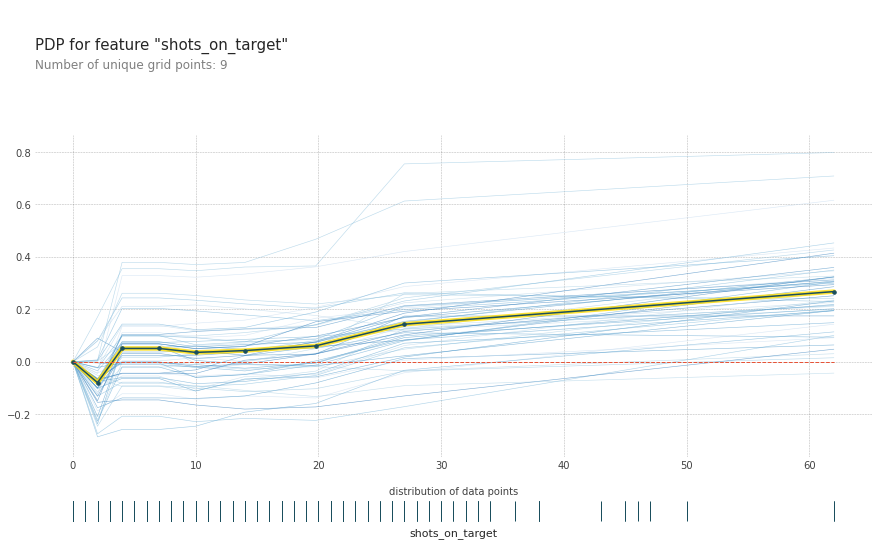

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot

pipe = FW_best_model.fit(FW_train_X,FW_train_y)

target_feature='shots_on_target'

isolated = pdp_isolate(
    model=pipe,
    dataset=FW_val_X,
    model_features=FW_val_X.columns,
    feature=target_feature
)

pdp_plot(
    isolated,
    feature_name=target_feature,
    plot_lines=True,  
    frac_to_plot=50,  
    plot_pts_dist=True,
)

유효슈팅수는 많을수록 좋아보인다.

(<Figure size 1080x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff5a8f59ad0>,
  'pdp_ax': {'_pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff5a8f26890>,
   '_count_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff5a8eddf90>}})

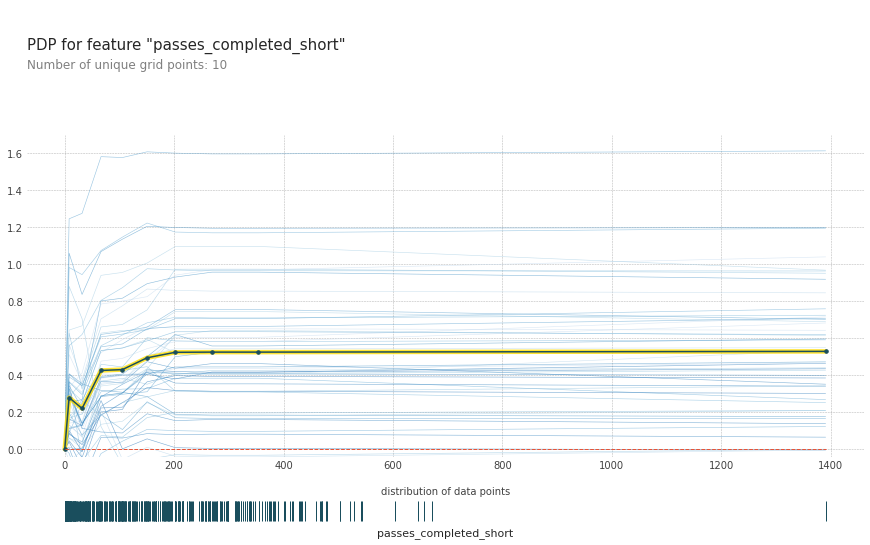

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot

target_feature='passes_completed_short'

isolated = pdp_isolate(
    model=FW_best_model,
    dataset=FW_val_X,
    model_features=FW_val_X.columns,
    feature=target_feature
)

pdp_plot(
    isolated,
    feature_name=target_feature,
    plot_lines=True,  
    frac_to_plot=50,  
    plot_pts_dist=True,
)

전방에서 공격을 하는 포지션인 만큼 전진 패스는 아주 중요한 찬스를 만들수 있다. 때문에 전진 패스는 value에 양(+)의 효과를 미친다. 하지만 일정수준 이상이 되면 의미가 없어보인다.(사실상 전방에 위치해 있기에 폴스나인과 같은 연계 위주 플레이어 외에는 전진패스수가 타 포지션에 비해 적을 것이다.)

In [ ]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [ ]:
target_features = ['assists','passes_completed_short']

interaction = pdp_interact(
    model=pipe,
    dataset=FW_val_X,
    model_features=FW_val_X.columns,
    features=target_features,
)


(<Figure size 1080x1080 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff5ac23b190>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff5ab757550>})

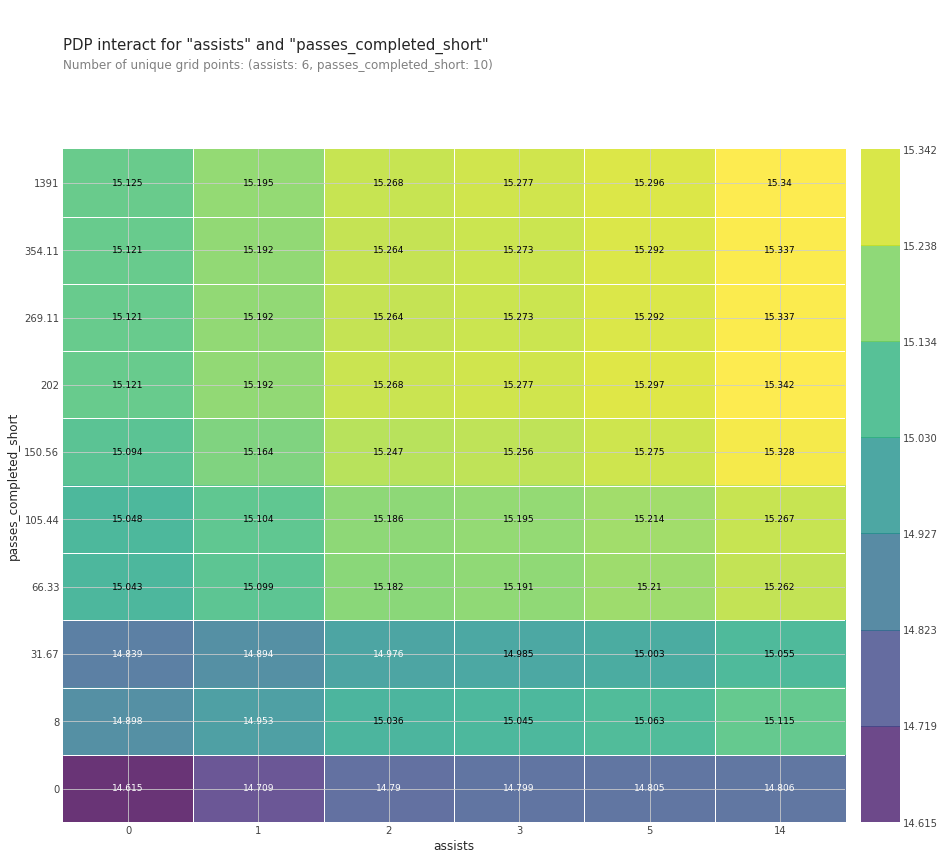

In [ ]:
pdp_interact_plot(interaction, plot_type="grid", feature_names=target_features, figsize=(15,15))

짧은 전진패스를 많이해도 assists가 많아야 value증가가 더 큰것을 볼 수 있다. (전진패스 성공이 8개이고 어시스트가 2개이상인 경우는 전진패스가 31개이고  어시스트가 2개이상인경우보다 value의 증가가 큰다.)
- 연계플레이 위주의 공격수는 공격포인트(의미있는 전진패스) 중요!

### MF

#### 특성 중요도

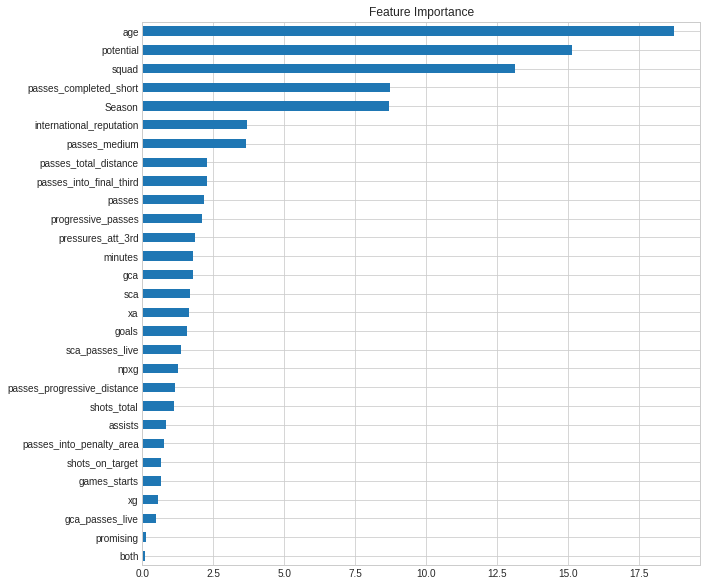

In [ ]:
plt.figure(figsize=(10,10))
MF_FI = MF_best_model.named_steps["transformedtargetregressor"].regressor_
importances = pd.Series(MF_FI.feature_importances_, MF_X.columns)
importances.sort_values().plot.barh()
plt.title("Feature Importance")
plt.show()

age, potentil, squad, passes_completed_short ,Season, international_reputation 트리 분리시 중요하다고 판단된다.

- age의 경우 수치형 변수고 squad의 경우 카디널리티가 높아서 그럴수 있다.
- 추가해준 international_reputation과 potential은 도움이 되는 변수라 정말 다행이다.
- 그 후에는 pass관련 feature들로 구성된다.
- 그러다 마지막으로 오면 내가 야심차게 준비한 양발 변수와 유망주변수가 있다. 너무 소수가 존재해서 그럴까 중요해 보이지 않는다. 


#### PDP plot
- passes_completed_short와 passes_medium 변수를 살펴볼 것이다.

(<Figure size 1080x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff5ab1068d0>,
  'pdp_ax': {'_pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff5ab393b50>,
   '_count_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff5a8d3a450>}})

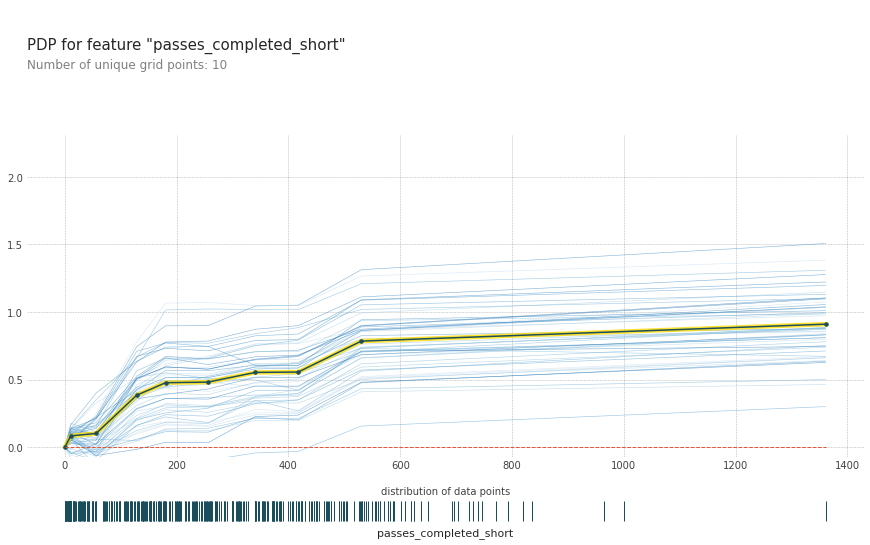

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot

pipe = MF_best_model.fit(MF_train_X,MF_train_y)

target_feature='passes_completed_short'

isolated = pdp_isolate(
    model=pipe,
    dataset = MF_val_X,
    model_features=MF_val_X.columns,
    feature=target_feature
)

pdp_plot(
    isolated,
    feature_name=target_feature,
    plot_lines=True,  
    frac_to_plot=50,  
    plot_pts_dist=True,
)

공격수와 다르게 짧은 전진패스는 증가할수록 좋아보임(공격수 보다 후방에서 위치해서 전진패스 기회가 더 많기도하고 공격을 전계시키는데 반드시 필요한 패스이기 때문)

(<Figure size 1080x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff5a8bde710>,
  'pdp_ax': {'_pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff5a8ba0350>,
   '_count_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff5a8b4c910>}})

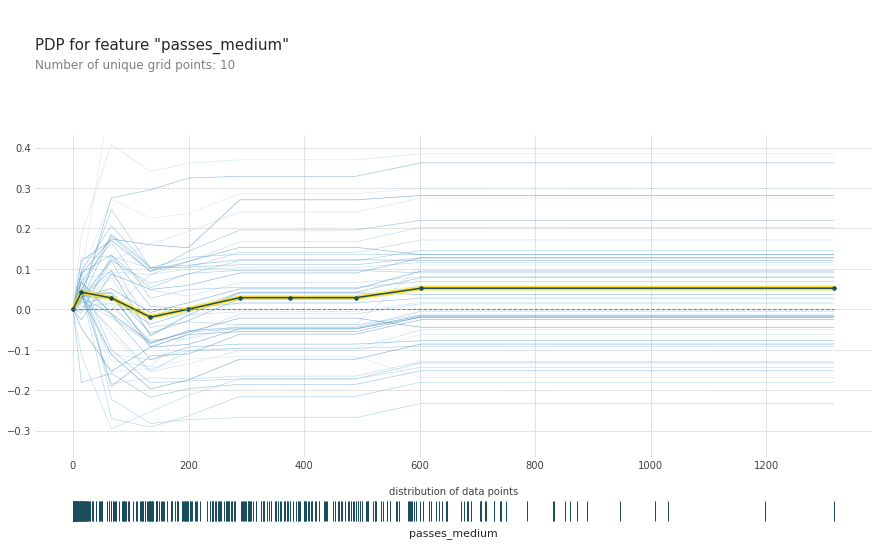

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot

target_feature='passes_medium'

isolated = pdp_isolate(
    model=MF_best_model,
    dataset=MF_val_X,
    model_features=MF_val_X.columns,
    feature=target_feature
)

pdp_plot(
    isolated,
    feature_name=target_feature,
    plot_lines=True,  
    frac_to_plot=50,  
    plot_pts_dist=True,
)

중거리 패스 수는 많을수록 value에 양의 영향을 미치지만 600개 이상이 되면 변동이 600개일때와 증가정도의 변화가 없어보인다.

- MF 포지션의 경우 공격 전계시 넓은 시야를 이용하여 중거리 패스를하면 반향전환과 빠른 공격 전계가 가능하여 중요하다.

### DF

#### 특성 중요도

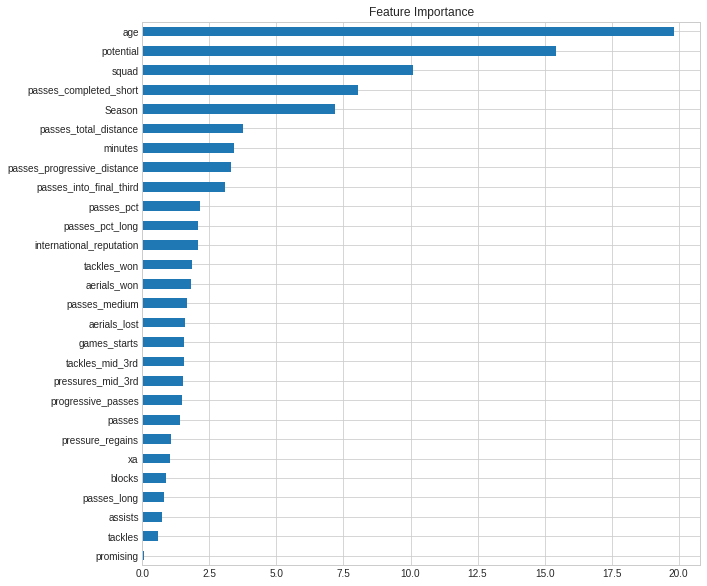

In [ ]:
plt.figure(figsize=(10,10))
DF_FI = DF_best_model.named_steps["transformedtargetregressor"].regressor_
importances = pd.Series(DF_FI.feature_importances_, DF_X.columns)
importances.sort_values().plot.barh()
plt.title("Feature Importance")
plt.show()

age, potentil, squad, passes_completed_short ,Season, passes_total_distance 가 중요해보인다.

- age의 경우 수치형 변수고 squad의 경우 카디널리티가 높아서 그럴수 있다.
- 추가해준 potential은 도움이 되는 변수라 정말 다행이다. 하지만 수비수의 경우 다른 필드프레이어와 달리 명성이 중요한 변수로 보이지 않는다..
- 또한 신기한점은 수비 기록에 대한 변수보다 pass기록이 더 상단에 있다.

#### PDP plot
- passes_pct_long(빌드업)과 tackles_won(수비) 변수를 살펴볼 것이다.

(<Figure size 1080x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff5a886ed50>,
  'pdp_ax': {'_pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff5a870c110>,
   '_count_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff5a873e990>}})

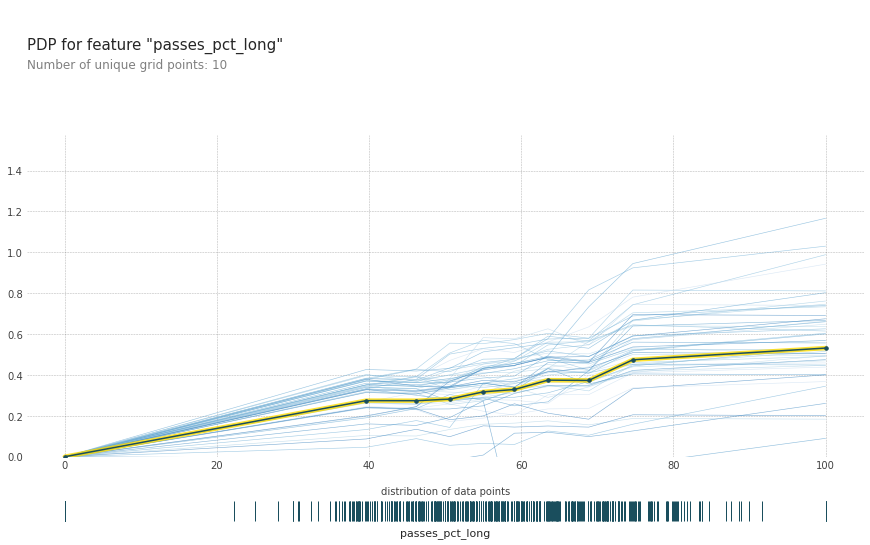

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot

pipe = DF_best_model.fit(DF_train_X,DF_train_y)

target_feature='passes_pct_long'

isolated = pdp_isolate(
    model=pipe,
    dataset = DF_val_X,
    model_features=DF_val_X.columns,
    feature=target_feature
)

pdp_plot(
    isolated,
    feature_name=target_feature,
    plot_lines=True,  
    frac_to_plot=50,  
    plot_pts_dist=True,
)

장거리 패스 성공률이 높을수록 value는 올라간다. 
- 낮은거 보다 당연히 좋은거지만 빌드업 능력이 수비수에게도 상당히 요구됨을 보여준다.

(<Figure size 1080x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff5a85fec10>,
  'pdp_ax': {'_pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff5a86412d0>,
   '_count_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff5a852e8d0>}})

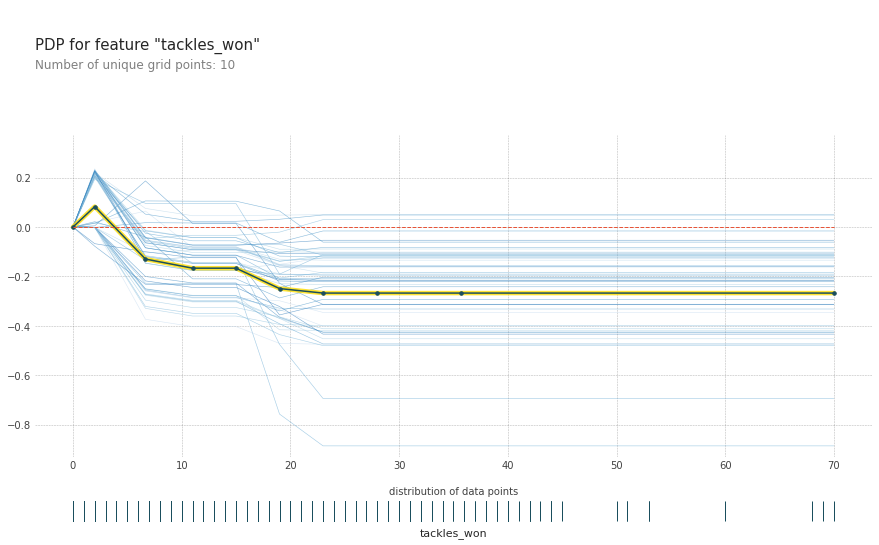

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot

target_feature='tackles_won'

isolated = pdp_isolate(
    model=DF_best_model,
    dataset=DF_val_X,
    model_features=DF_val_X.columns,
    feature=target_feature
)

pdp_plot(
    isolated,
    feature_name=target_feature,
    plot_lines=True,  
    frac_to_plot=50,  
    plot_pts_dist=True,
)

태클횟수가 늘어날 수록 value에 음(-)영향을 미친다는 것은 이상하다..

In [ ]:
for_tackle = df18.loc[df18['position']=='DF',['player', 'league', 'tackles_won','value']]
print('리그별 수비 평균 태클 수')
print(for_tackle.groupby('league')['tackles_won'].mean().sort_values(ascending=False))
print('리그별 수비 평균 value')
print(for_tackle.groupby('league')['value'].mean().sort_values(ascending=False))

리그별 수비 평균 태클 수
league
Bundesliga        18.017391
Serie A           17.763636
Ligue 1           17.507042
La Liga           16.845638
Premier League    16.231250
Name: tackles_won, dtype: float64
리그별 수비 평균 value
league
Premier League    1.132578e+07
La Liga           7.615839e+06
Bundesliga        7.501696e+06
Serie A           5.830879e+06
Ligue 1           4.949366e+06
Name: value, dtype: float64


타리그에비해 빅클럽이 많아 경기수준이 높은 프리미어리그에서 높은 value 대비  tackle수가 낮기 때문으로 보인다..

In [ ]:
target_features = ['tackles_won','squad']

encoder = OrdinalEncoder(cols='squad')
DF_train_X_encoded = encoder.fit_transform(DF_train_X)
DF_val_X_encoded = encoder.transform(DF_val_X)

mappings = encoder.mapping
mapping_data = list(filter(lambda x: x["col"] == 'squad', mappings))
maps = mapping_data[0]['mapping']

interaction = pdp_interact(
    model=pipe,
    dataset=DF_val_X_encoded,
    model_features=DF_val_X.columns,
    features=target_features,
)


Text(0.5, 1.0, "PDP of ['tackles_won', 'squad'], decoded categorical")

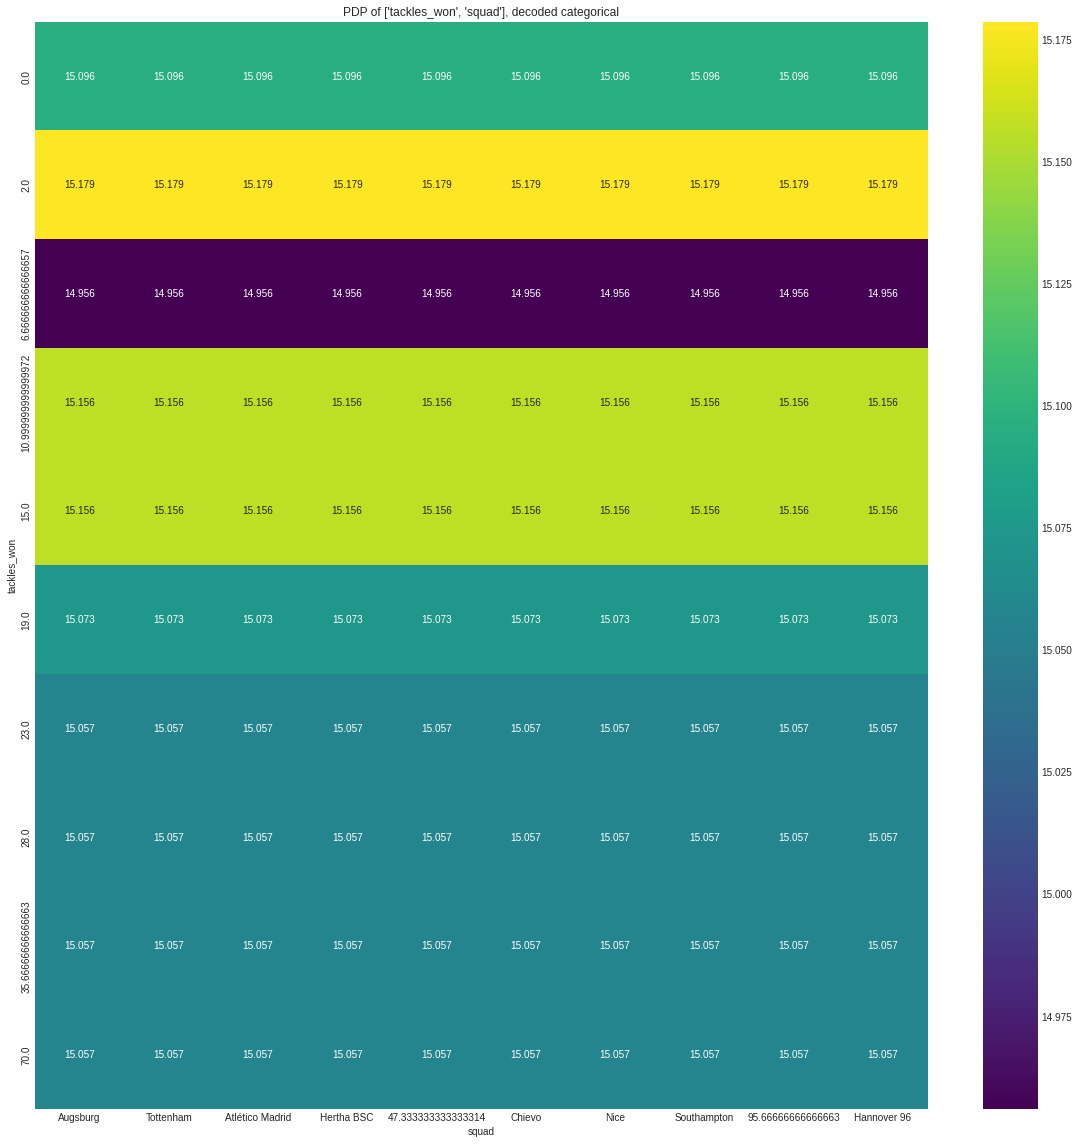

In [ ]:
encoded_features = maps.values.tolist()
original_features = maps.index.tolist()

pdp_pivoted_data = interaction.pdp.pivot_table(
    values="preds", columns=target_features[1], index=target_features[0]
)


# pdp_pivoted_data DataFrame의 columndms categorical인 marital-status입니다. column을 rename합시다.
pdp_pivoted_data.rename(
    columns=dict(zip(encoded_features, original_features)), inplace=True
)
plt.figure(figsize=(20,20))
sns.heatmap(data=pdp_pivoted_data, annot=True, fmt=".3f", cmap="viridis")
plt.title(f"PDP of {target_features}, decoded categorical")

팀, 태클 상호작용 pdp plot을 확인해보면 팀이 너무 많아 정확한 판단은 불가능하지만 태클 단변수로만 봤을때 비해 낮은 부분은 낮게 나온다.. 


### GK

#### 특성 중요도

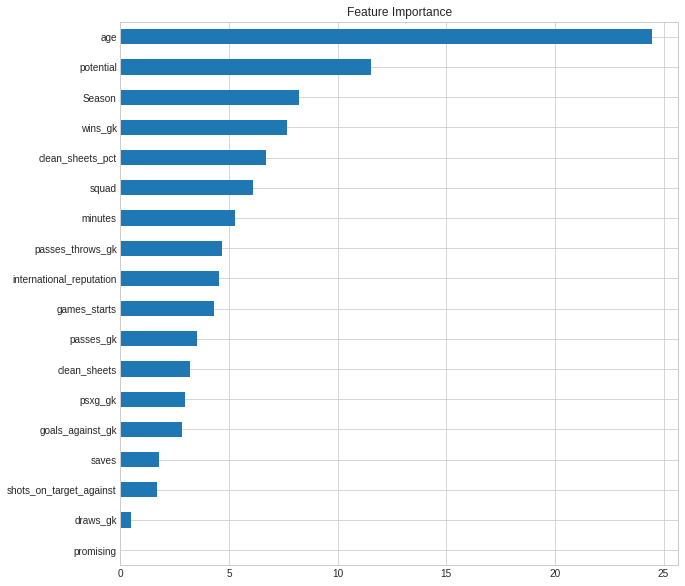

In [ ]:
plt.figure(figsize=(10,10))
GK_FI = GK_best_model.named_steps["transformedtargetregressor"].regressor_
importances = pd.Series(GK_FI.feature_importances_, GK_X.columns)
importances.sort_values().plot.barh()
plt.title("Feature Importance")
plt.show()

age, potentil, Season, wins_gk , clean_sheets, squad 트리 분리시 중요하다고 판단된다.

- age의 경우 수치형 변수고 squad의 경우 카디널리티가 높아서 그럴수 있다.
- 추가해준 potential은 도움이 되는 변수라 정말 다행이다.
- 그 후에는 gk관련 feature들로 구성된다.

#### PDP plot
wins_gk와 clean_sheets_pct 변수를 살펴볼 것이다.

(<Figure size 1080x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff5a7bd1150>,
  'pdp_ax': {'_pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff5a7bbd650>,
   '_count_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff5a6b54a50>}})

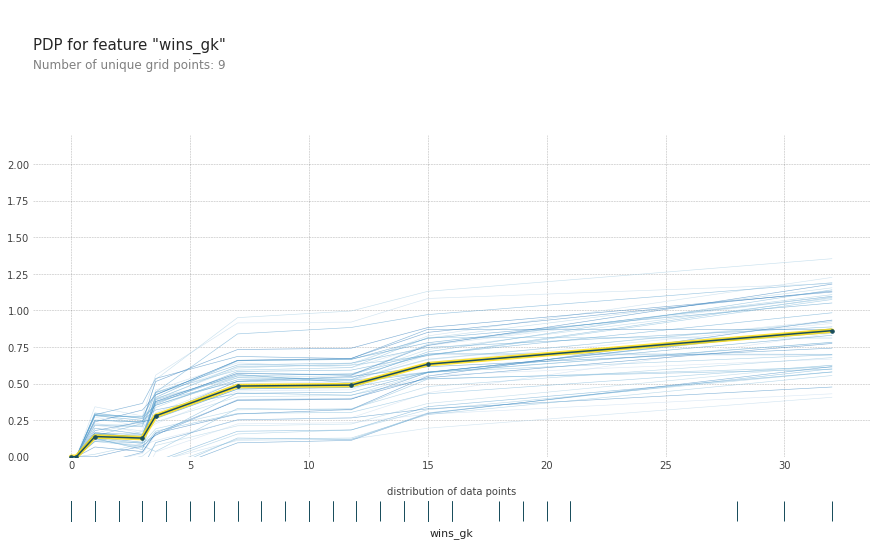

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot

pipe = GK_best_model.fit(GK_train_X,GK_train_y)

target_feature='wins_gk'

isolated = pdp_isolate(
    model=pipe,
    dataset = GK_val_X,
    model_features=GK_val_X.columns,
    feature=target_feature
)

pdp_plot(
    isolated,
    feature_name=target_feature,
    plot_lines=True,  
    frac_to_plot=50,  
    plot_pts_dist=True,
)

승리수가 (득점보다 조금 실점하는 것이 중요하기에) value에 지속적으로 양의 영향을 준다.

(<Figure size 1080x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff5a7d71ad0>,
  'pdp_ax': {'_pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff5a69ee4d0>,
   '_count_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7ff5a699cdd0>}})

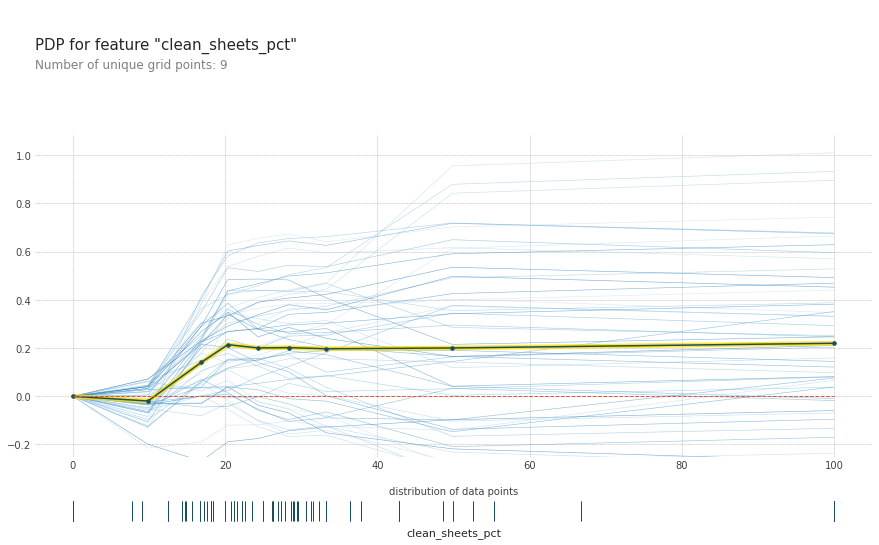

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot

pipe = GK_best_model.fit(GK_train_X,GK_train_y)

target_feature='clean_sheets_pct'

isolated = pdp_isolate(
    model=pipe,
    dataset = GK_val_X,
    model_features=GK_val_X.columns,
    feature=target_feature
)

pdp_plot(
    isolated,
    feature_name=target_feature,
    plot_lines=True,  
    frac_to_plot=50,  
    plot_pts_dist=True,
)

클린시트비율이 증가할수록 value가 양의 영향을 준다. 단 20이상이면 변화량이 크게 변하진 않는다.

In [ ]:
GK[['player','games','clean_sheets_pct','value']].sort_values(by='clean_sheets_pct', ascending=False)

,player,games,clean_sheets_pct,value
4117,John Ruddy,1.0,100.0,3000000.0
1889,Paulo Gazzaniga,1.0,100.0,1000000.0
2411,Gaëtan Poussin,1.0,100.0,800000.0
225,Tom Starke,2.0,100.0,10000.0
3387,Dimitry Bertaud,1.0,100.0,500000.0
...,...,...,...,...
3492,Yoan Cardinale,3.0,0.0,2000000.0
824,Marco Silvestri,2.0,0.0,35000.0
2538,Danny Ward,14.0,0.0,8000000.0
409,Luca Crosta,1.0,0.0,20000.0


비율이 너무 높으면 출전 경기수가 작은 경우가 대부분이기 때문인 것ㄷ으로 보인다.

# Part3. 결론 도출

## 3-1 17/18, 18/19, 19/20 시즌 맨유 경기 결과 분석

In [ ]:
for idx,col in enumerate(match.columns):
    print(col,end=' ')
    if (idx//10)>=1 and (idx%10)==0:
        print('\n')

link_match season date home_team away_team result_full result_ht home_clearances home_corners home_fouls_conceded home_offsides 

home_passes home_possession home_red_cards home_shots home_shots_on_target home_tackles home_touches home_yellow_cards away_clearances away_corners 

away_fouls_conceded away_offsides away_passes away_possession away_red_cards away_shots away_shots_on_target away_tackles away_touches away_yellow_cards 

goal_home_ft goal_away_ft sg_match_ft goal_home_ht goal_away_ht sg_match_ht clearances_avg_H corners_avg_H fouls_conceded_avg_H offsides_avg_H 

passes_avg_H possession_avg_H red_cards_avg_H shots_avg_H shots_on_target_avg_H tackles_avg_H touches_avg_H yellow_cards_avg_H goals_scored_ft_avg_H goals_conced_ft_avg_H 

sg_match_ft_acum_H goals_scored_ht_avg_H goals_conced_ht_avg_H sg_match_ht_acum_H performance_acum_H clearances_avg_A corners_avg_A fouls_conceded_avg_A offsides_avg_A passes_avg_A 

possession_avg_A red_cards_avg_A shots_avg_A shots_on_target_avg

In [ ]:
match = match[(match['season'].isin(['17/18','18/19','19/20']))]
match = match[(match['home_team']=='Manchester United')|(match['away_team']=='Manchester United')].reset_index(drop=True)

In [ ]:
match.head()

,link_match,season,date,home_team,away_team,result_full,result_ht,home_clearances,home_corners,home_fouls_conceded,...,tackles_avg_away,touches_avg_away,yellow_cards_avg_away,goals_scored_ft_avg_away,goals_conced_ft_avg_away,sg_match_ft_acum_away,goals_scored_ht_avg_away,goals_conced_ht_avg_away,sg_match_ht_acum_away,performance_acum_away
0,https://www.premierleague.com/match/22704,17/18,2018-05-04,Brighton and Hove Albion,Manchester United,1-0,0-0,22.0,5.0,5.0,...,14.7,720.7,1.7,1.91,0.77,40.0,0.80,0.40,14.0,73.3
1,https://www.premierleague.com/match/22555,17/18,2018-01-01,Everton,Manchester United,0-2,0-0,32.0,6.0,11.0,...,14.0,695.6,1.7,2.05,0.76,27.0,0.90,0.38,11.0,69.8
2,https://www.premierleague.com/match/22567,17/18,2018-01-15,Manchester United,Stoke City,3-0,2-0,12.0,6.0,14.0,...,18.0,555.2,1.2,1.05,2.14,-24.0,0.50,0.91,-9.0,30.3
3,https://www.premierleague.com/match/22624,17/18,2018-03-05,Crystal Palace,Manchester United,2-3,1-0,41.0,3.0,10.0,...,14.5,713.0,1.8,1.89,0.71,33.0,0.79,0.39,11.0,70.2
4,https://www.premierleague.com/match/22637,17/18,2018-03-10,Manchester United,Liverpool,2-1,2-0,40.0,1.0,10.0,...,17.7,789.2,1.2,2.31,1.10,35.0,1.00,0.45,16.0,69.0


#### 맨유 홈경기 더미 변수

In [ ]:
match['MU_Home'] =0
match['MU_Home'] = match['home_team'].apply(lambda x: 1 if x == 'Manchester United' else 0 )

In [ ]:
def home_result(x):
    home_score = x.split('-')[0]
    away_score = x.split('-')[1]
    if home_score == away_score:
        return 'Draw'
    elif home_score > away_score:
        return 'Win'
    else: 
        return 'Lose'

def away_result(x):
    home_score = x.split('-')[0]
    away_score = x.split('-')[1]
    if home_score == away_score:
        return 'Draw'
    elif home_score < away_score:
        return 'Win'
    else: 
        return 'Lose'

#### 경기 결과 변수

In [ ]:
match['result']=np.NAN

In [ ]:
match.loc[match[match['MU_Home']==1].index,'result'] = match.loc[match[match['MU_Home']==1].index,'result_full'].apply(lambda x: home_result(x))
match.loc[match[match['MU_Home']==0].index,'result'] = match.loc[match[match['MU_Home']==0].index,'result_full'].apply(lambda x: away_result(x))

In [ ]:
match.MU_Home.isnull().sum()

0

#### 상대팀 변수

In [ ]:
match['opponent'] =np.NAN

In [ ]:
match.loc[match[match['MU_Home']==1].index,'opponent'] = match.loc[match[match['MU_Home']==1].index,'away_team']
match.loc[match[match['MU_Home']==0].index,'opponent'] = match.loc[match[match['MU_Home']==0].index,'home_team']

In [ ]:
match.opponent.isnull().sum()

0

### 맨유는 시즌별 상대팀에 따른 경기 결과


In [ ]:
MU18 = match[match['season']=='17/18']
MU19 = match[match['season']=='18/19']
MU20 = match[match['season']=='19/20']

In [ ]:
MU18[MU18['result']=='Lose'].groupby('opponent')['result'].count()

opponent
Brighton and Hove Albion    1
Chelsea                     1
Huddersfield Town           1
Manchester City             1
Newcastle United            1
Tottenham Hotspur           1
West Bromwich Albion        1
Name: result, dtype: int64

In [ ]:
MU18[MU18['result']=='Win'].groupby('opponent')['result'].count()

opponent
AFC Bournemouth             2
Arsenal                     2
Brighton and Hove Albion    1
Burnley                     1
Chelsea                     1
Crystal Palace              2
Everton                     2
Huddersfield Town           1
Leicester City              1
Liverpool                   1
Manchester City             1
Newcastle United            1
Southampton                 1
Stoke City                  1
Swansea City                2
Tottenham Hotspur           1
Watford                     2
West Bromwich Albion        1
West Ham United             1
Name: result, dtype: int64

In [ ]:
MU18[MU18['result']=='Draw'].groupby('opponent')['result'].count()

opponent
Burnley            1
Leicester City     1
Liverpool          1
Southampton        1
Stoke City         1
West Ham United    1
Name: result, dtype: int64

해당 시즌 리그 경기는 2위로 마무리하면서 준수한 결과를 가져옴 패배한 경기도 6경기뿐

더비 결과 
- 노스웨스트(vs리버풀) 1승 1무
- 맨체스터(vs 맨체스터 시티) 1승 1패

In [ ]:
MU19[MU19['result']=='Lose'].groupby('opponent')['result'].count()

opponent
Arsenal                     1
Brighton and Hove Albion    1
Cardiff City                1
Everton                     1
Liverpool                   1
Manchester City             2
Tottenham Hotspur           1
West Ham United             1
Wolverhampton Wanderers     1
Name: result, dtype: int64

In [ ]:
MU19[MU19['result']=='Win'].groupby('opponent')['result'].count()

opponent
AFC Bournemouth             2
Brighton and Hove Albion    1
Burnley                     1
Cardiff City                1
Crystal Palace              1
Everton                     1
Fulham                      2
Huddersfield Town           1
Leicester City              2
Newcastle United            2
Southampton                 1
Tottenham Hotspur           1
Watford                     2
West Ham United             1
Name: result, dtype: int64

In [ ]:
MU19[MU19['result']=='Draw'].groupby('opponent')['result'].count()

opponent
Arsenal                    1
Burnley                    1
Chelsea                    2
Crystal Palace             1
Huddersfield Town          1
Liverpool                  1
Southampton                1
Wolverhampton Wanderers    1
Name: result, dtype: int64

리그 6위라는 실망스러운 성과
더비전에서 한번도 못이김

더비결과
- 노스웨스트(vs리버풀) 1무 1패
- 맨체스터(vs맨체스터 시티)  2패

In [ ]:
MU20[MU20['result']=='Lose'].groupby('opponent')['result'].count()

opponent
AFC Bournemouth     1
Arsenal             1
Burnley             1
Crystal Palace      1
Liverpool           1
Newcastle United    1
Watford             1
West Ham United     1
Name: result, dtype: int64

In [ ]:
MU20[MU20['result']=='Win'].groupby('opponent')['result'].count()

opponent
AFC Bournemouth             1
Aston Villa                 1
Brighton and Hove Albion    2
Burnley                     1
Chelsea                     2
Crystal Palace              1
Leicester City              2
Manchester City             2
Newcastle United            1
Norwich City                2
Sheffield United            1
Tottenham Hotspur           1
Watford                     1
Name: result, dtype: int64

In [ ]:
MU20[MU20['result']=='Draw'].groupby('opponent')['result'].count()

opponent
Arsenal                    1
Aston Villa                1
Everton                    2
Liverpool                  1
Sheffield United           1
Southampton                2
Tottenham Hotspur          1
West Ham United            1
Wolverhampton Wanderers    2
Name: result, dtype: int64

3위라는 준수한 결과
더비결과
- 노스웨스트(vs리버풀) 1무 1패
- 맨체스터(vs맨체스터 시티)  2무


### 패배한 경기에서 부족했던 부분은???

In [ ]:
Home = match[match['MU_Home']==1]
Away = match[match['MU_Home']==0]

In [ ]:
Home_Lose = Home[Home['result']=='Lose']
Home_Not_Lose = Home[Home['result']!='Lose']
Away_Lose = Away[Away['result']=='Lose']
Away_Not_Lose = Away[Away['result']!='Lose']

In [ ]:
HL = Home_Lose.select_dtypes('number')
HNL = Home_Not_Lose.select_dtypes('number')
AL = Away_Lose.select_dtypes('number')
ANL = Away_Not_Lose.select_dtypes('number')

In [ ]:
Comp_Home = (HL/Home.mean())
Comp_Away = (AL/Away.mean())

In [ ]:
Comp_Home = Comp_Home[Comp_Home.columns[Comp_Home.columns.str.contains('home')]]
Comp_Away = Comp_Away[Comp_Away.columns[Comp_Away.columns.str.contains('away')]]

In [ ]:
Comp_Home.columns = Comp_Home.columns.str.replace('home_','')
Comp_Home.columns = Comp_Home.columns.str.replace('_home','')
Comp_Away.columns = Comp_Away.columns.str.replace('away_','')
Comp_Away.columns = Comp_Away.columns.str.replace('_away','')


In [ ]:
Comp_Home.columns==Comp_Away.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [ ]:
Comp=pd.concat([Comp_Home,Comp_Away])

In [ ]:
Comp[Comp<1]

,clearances,corners,fouls_conceded,offsides,passes,possession,red_cards,shots,shots_on_target,tackles,...,tackles_avg,touches_avg,yellow_cards_avg,goals_scored_ft_avg,goals_conced_ft_avg,sg_match_ft_acum,goals_scored_ht_avg,goals_conced_ht_avg,sg_match_ht_acum,performance_acum
22,0.975831,0.346505,NaN,NaN,0.614651,0.627640,0.0,0.531469,0.848214,NaN,...,0.905730,0.975059,0.759036,NaN,0.559682,NaN,NaN,0.560123,NaN,NaN
26,0.631420,0.693009,0.723810,NaN,NaN,NaN,0.0,0.930070,0.678571,0.996503,...,0.958619,NaN,0.975904,NaN,0.727587,NaN,0.926302,0.912793,NaN,NaN
39,0.803625,0.866261,0.995238,0.876923,0.911701,NaN,0.0,NaN,0.848214,0.730769,...,NaN,NaN,0.813253,NaN,NaN,0.000000,NaN,NaN,-0.130435,0.823572
57,0.746224,NaN,0.814286,NaN,NaN,NaN,0.0,NaN,NaN,0.996503,...,NaN,0.978870,NaN,0.936262,NaN,0.904639,NaN,NaN,NaN,0.980051
72,0.688822,0.173252,0.904762,0.000000,0.758505,0.652462,0.0,0.797203,0.169643,0.863636,...,NaN,0.981410,NaN,0.984139,NaN,NaN,NaN,NaN,NaN,NaN
85,0.344411,NaN,0.723810,0.000000,NaN,NaN,0.0,NaN,0.508929,0.597902,...,NaN,NaN,NaN,NaN,0.466402,0.278351,NaN,0.000000,0.260870,NaN
110,0.746224,0.866261,0.995238,0.876923,NaN,NaN,0.0,NaN,NaN,0.664336,...,NaN,0.990584,NaN,0.835189,NaN,0.626289,0.949174,0.995774,NaN,0.812042
0,0.851415,NaN,0.270998,NaN,NaN,NaN,0.0,NaN,0.604240,0.525952,...,0.971253,NaN,0.918483,0.984358,0.750385,NaN,0.909816,0.908729,NaN,NaN
10,0.761792,NaN,NaN,NaN,NaN,NaN,0.0,0.708564,0.604240,0.854671,...,0.958039,0.994278,0.756398,NaN,0.243631,NaN,NaN,0.272619,0.788018,NaN
23,0.761792,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.805654,0.788927,...,0.951432,NaN,0.918483,NaN,0.672423,NaN,0.921189,0.863292,NaN,NaN


유의미한 정보가 없어보인다.

## 3.2 감독 전술과 19/20 시즌 기록 분석

솔샤르

- 스타일 : 선 굵고 직선적(측면 돌파 강조)인 공격 축구를 추구



#### FW

In [ ]:
FW20 =df20[df20['position'] == 'FW'][['position2']+FW_col+["aerials_won_pct"]]
FW20_MU = FW20[FW20['squad']=='Manchester Utd'].sort_values(by='games_starts',ascending=False)
FW20_MU[['player','position2','games', 'age','foot','games_starts', 'height','goals','assists','xg','xa','shots_on_target',"passes_into_penalty_area","crosses_into_penalty_area","dribbles_completed_pct","players_dribbled_past","aerials_won_pct"]]

,player,position2,games,age,foot,games_starts,height,goals,assists,xg,xa,shots_on_target,passes_into_penalty_area,crosses_into_penalty_area,dribbles_completed_pct,players_dribbled_past,aerials_won_pct
1417,Anthony Martial,Forward - Centre-Forward,32,23,right,31,181,17,6,10.9,4.1,38,33,1,61.5,66,25.9
1423,Marcus Rashford,Forward - Left Winger,31,21,right,31,185,17,7,17.3,4.6,38,67,4,54.5,77,30.3
1412,Daniel James,Forward - Left Winger,33,21,right,26,170,3,6,3.6,4.0,19,29,9,44.4,30,23.5
1410,Mason Greenwood,Forward - Right Winger,31,17,both,12,181,10,1,3.6,0.7,20,9,1,67.7,21,30.0
1415,Jesse Lingard,Forward - Right Winger,22,26,right,9,174,1,0,2.7,0.9,6,10,0,50.0,10,9.1
1402,Tahith Chong,Forward - Right Winger,3,19,left,0,185,0,0,0.1,0.0,0,0,0,33.3,1,0.0
1411,Odion Ighalo,Forward - Centre-Forward,11,30,right,0,181,0,0,1.5,0.1,3,1,0,57.1,4,0.0


중앙 공격수(Martial)와 측면 공격수(Rashford, Greenwood)가 준수한 플레이를 보여주었다. 

#### 장점
- 준수한 실력
- 유망주로 구성
- 직선적인 스타일에 맞게 드리블 성공률이 모두 평균 이상

In [ ]:
dribbles_mean = FW20['dribbles_completed_pct'].mean()

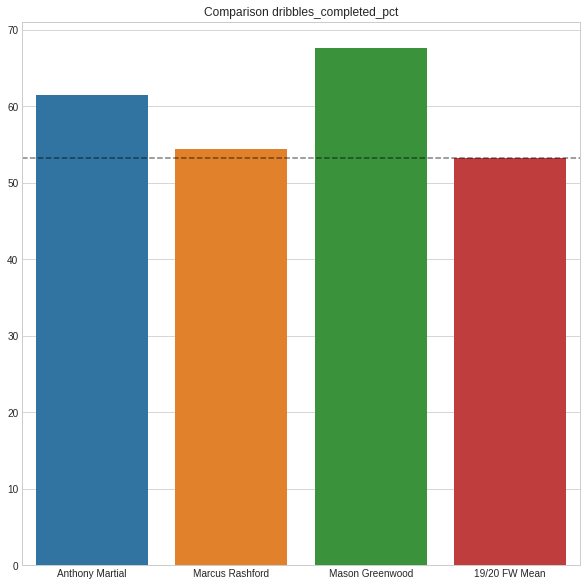

In [ ]:
plt.figure(figsize=(10,10))
sns.barplot(x=['Anthony Martial', 'Marcus Rashford', 'Mason Greenwood', '19/20 FW Mean'], y= [FW20['dribbles_completed_pct'][1417],FW20['dribbles_completed_pct'][1423], FW20['dribbles_completed_pct'][1410], dribbles_mean])
plt.title('Comparison dribbles_completed_pct')
plt.axhline(dribbles_mean, c='black', linestyle='--',alpha=0.5)

#### 단점
- 베테랑 선수의 부제
- 공중볼 경합 능력 부족

In [ ]:
aerials_mean = FW20['aerials_won_pct'].mean()

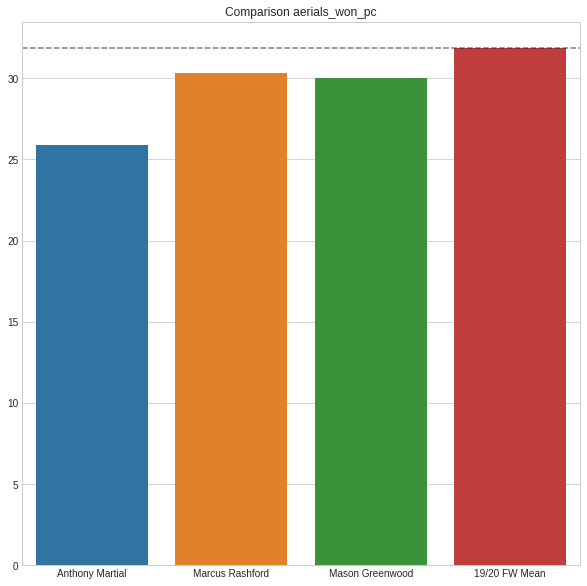

In [ ]:
plt.figure(figsize=(10,10))
sns.barplot(x=['Anthony Martial', 'Marcus Rashford', 'Mason Greenwood', '19/20 FW Mean'], y= [FW20['aerials_won_pct'][1417],FW20['aerials_won_pct'][1423], FW20['aerials_won_pct'][1410], aerials_mean])
plt.title('Comparison aerials_won_pc')
plt.axhline(aerials_mean, c='black', linestyle='--',alpha=0.5)

#### MF

In [ ]:
MF20 =df20[df20['position'] == 'MF'][['position2']+MF_col]
MF20_MU = MF20[MF20['squad']=='Manchester Utd'].sort_values(by='games_starts',ascending=False)
MF20_MU[['player','position2','games', 'age','games_starts', 'height','goals','assists','xa',"passes_into_penalty_area","crosses_into_penalty_area","aerials_won_pct", "passes_pct_medium", 'pressure_regain_pct','dribbles_completed_pct']]

,player,position2,games,age,games_starts,height,goals,assists,xa,passes_into_penalty_area,crosses_into_penalty_area,aerials_won_pct,passes_pct_medium,pressure_regain_pct
1406,Fred,Midfielder - Central Midfield,29,26,23,169,0,0,2.5,15,3,33.3,91.3,27.4
1420,Scott McTominay,Midfielder - Central Midfield,27,22,20,193,4,1,0.7,11,2,59.2,86.7,32.1
1419,Nemanja MatiÄ‡,Midfielder - Defensive Midfield,21,30,18,194,0,2,1.2,12,1,60.0,92.6,28.6
1421,Andreas Pereira,Midfielder - Attacking Midfield,25,23,18,178,1,3,3.8,17,4,32.5,77.4,26.6
1404,Bruno Fernandes,Midfielder - Attacking Midfield,14,24,14,179,8,7,2.5,23,2,16.7,77.5,25.0
1422,Paul Pogba,Midfielder - Central Midfield,16,26,13,191,1,3,2.7,27,1,73.0,89.0,35.2
1418,Juan Mata,Midfielder - Attacking Midfield,19,31,8,170,0,2,2.0,18,2,30.0,84.0,29.7
1407,James Garner,Midfielder - Defensive Midfield,1,18,0,182,0,0,0.0,0,0,0.0,100.0,0.0
1409,Angel Gomes,Midfielder - Attacking Midfield,2,18,0,168,0,0,0.1,2,0,0.0,80.0,9.1


브루노 페르난데스의 경우 20년 1월에 들어와 플레이 메이커로써의 역할을 잘 수행하고 준수한 기록을 보여주었다. 

하지만 주전 CM 프레드의 경우 압박능력이 매우 부족해 보인다. 맥토미니는 연계능력이 부족해보이며 포그바는 부상과 컨디션 문제로 경기 출전도 적고 좋은 기록을 보여주지 못했다. 

#### DF

In [ ]:
DF20 =df20[df20['position'] == 'DF'][['position2']+DF_col]
DF20_MU = DF20[DF20['squad']=='Manchester Utd'].sort_values(by='games_starts',ascending=False)
DF20_MU[['player','position2','games', 'age','games_starts','foot','height','assists',"passes_into_penalty_area", 'tackles_won',"crosses_into_penalty_area","aerials_won_pct", "passes_pct_medium", 'pressure_regain_pct', 'passes_progressive_distance','dribble_tackles']]

,player,position2,games,age,games_starts,foot,height,assists,passes_into_penalty_area,tackles_won,crosses_into_penalty_area,aerials_won_pct,passes_pct_medium,pressure_regain_pct,passes_progressive_distance,dribble_tackles
1416,Harry Maguire,Defender - Centre-Back,38,26,38,right,194,1,2,27,0,73.7,93.0,37.5,11790,14
1414,Victor LindelĂ¶f,Defender - Centre-Back,35,25,35,right,187,0,1,16,0,66.0,93.4,29.0,11016,12
1427,Aaron Wan-Bissaka,Defender - Right-Back,35,21,34,right,183,4,20,65,10,53.8,80.9,28.8,9484,45
1425,Luke Shaw,Defender - Left-Back,24,24,20,left,185,0,25,24,6,58.2,87.2,28.5,6228,15
1428,Brandon Williams,Defender - Left-Back,17,18,11,right,172,0,19,5,4,54.5,87.0,24.1,2692,8
1405,Timothy Fosu-Mensah,Defender - Right-Back,3,21,2,right,190,0,0,1,0,33.3,83.9,26.3,303,1
1413,Phil Jones,Defender - Centre-Back,2,27,2,right,185,0,0,2,0,70.6,90.0,50.0,398,2
1426,Axel Tuanzebe,Defender - Centre-Back,5,21,2,right,186,0,0,3,0,23.1,93.2,26.7,660,0
1401,Eric Bailly,Defender - Centre-Back,4,25,1,right,187,0,0,0,0,85.7,94.4,23.5,433,0
1403,Diogo Dalot,Defender - Right-Back,4,20,1,right,183,0,0,2,0,100.0,84.0,50.0,248,2


In [ ]:
tackles_mean=DF20[DF20['position2']=='Defender - Centre-Back']['tackles_won'].mean()
aerials_mean=DF20[DF20['position2']=='Defender - Centre-Back']['aerials_won_pct'].mean()

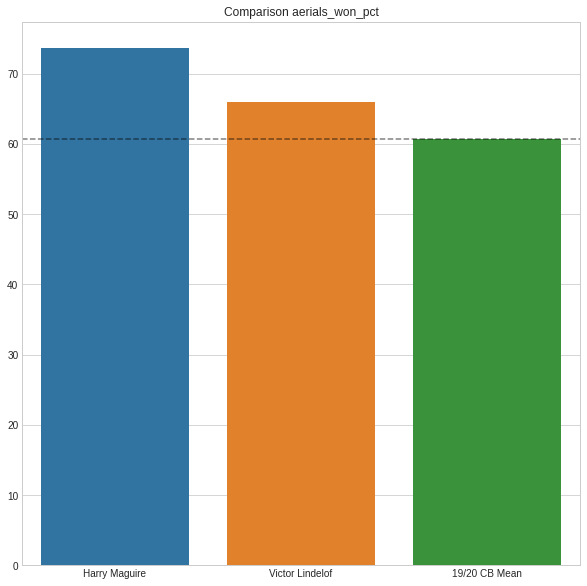

In [ ]:
plt.figure(figsize=(10,10))
sns.barplot(x=['Harry Maguire', 'Victor Lindelof', '19/20 CB Mean'], y= [DF20['aerials_won_pct'][1416],DF20['aerials_won_pct'][1414], aerials_mean])
plt.title('Comparison aerials_won_pct')
plt.axhline(aerials_mean, c='black', linestyle='--',alpha=0.5)

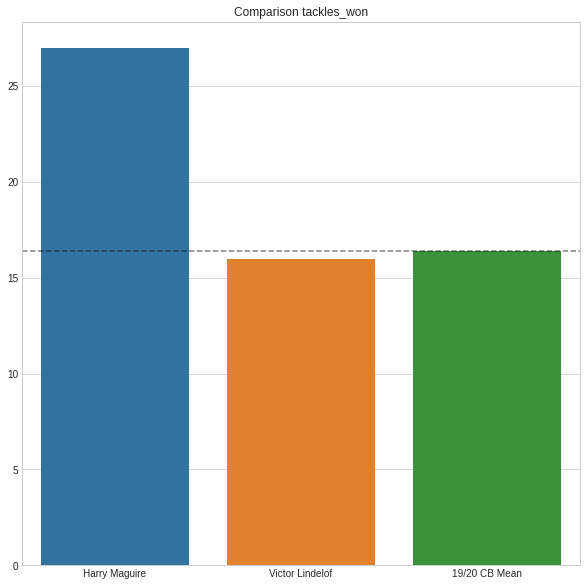

In [ ]:
plt.figure(figsize=(10,10))
sns.barplot(x=['Harry Maguire', 'Victor Lindelof', '19/20 CB Mean'], y= [DF20['tackles_won'][1416],DF20['tackles_won'][1414], tackles_mean])
plt.title('Comparison tackles_won')
plt.axhline(tackles_mean, c='black', linestyle='--',alpha=0.5)

매과이어는 큰 키와 공격적인 수비스타일로 태클과 공중볼 경합에서 좋은 기록을 냈다.
륀델로프의 경우에는 크게 좋은 기록을 낸 것으로 보이지는 않는다. (sub 자원들은 사실상 맨유의 골치거리로 크게 부진한 상황이다.)

매과이어와 륀델로프 모두 주발이 오른발이며 빌드업을 위해 왼발 잡이 센터백이 필요해보이고 무엇보다 활용 가능한 sub자원을 한명 정도는 영입할 필요가 있어보인다.

In [ ]:
GK20 =df20[df20['position'] == 'GK'][['position2']+GK_col]
GK20_MU = GK20[GK20['squad']=='Manchester Utd'].sort_values(by='games_starts',ascending=False)
GK20_MU[['player','age','games_starts','height']+keeper]

,player,age,games_starts,height,goals_against_gk,goals_against_per90_gk,shots_on_target_against,saves,save_pct,wins_gk,...,psxg_net_per90_gk,passes_pct_launched_gk,passes_gk,passes_throws_gk,pct_passes_launched_gk,passes_length_avg_gk,goal_kick_length_avg,crosses_stopped_pct_gk,def_actions_outside_pen_area_per90_gk,avg_distance_def_actions_gk
1408,David de Gea,28,38,192,36,0.95,125,92,0.736,18,...,0.05,38.6,669,148,33.8,34.3,33.9,5.3,0.29,13.3


로메로에 대한 데이터는 누락된 것으로 보인다.. 
데헤아는 잘하고 있으니... SUB 골키퍼 로메로도 있으니 GK은 넘어가겠다.

## 3.3 영입선수 (결론)

### FW

조건 : 베테랑, 공중볼 경합능력이 있는 선수 

In [ ]:
Veteran = (FW20['games_starts']>=25) & (FW20['xg']>10) & (FW20['aerials_won_pct']>np.percentile(FW20['aerials_won_pct'],85))& (FW20['age']>28)

In [ ]:
Veteran_idx = FW20[Veteran].index

In [ ]:
FW20['value']=FW_test_X.loc[Veteran_idx].value

In [ ]:
FW20[Veteran][['player','position2','age','foot','xg','goals','height','squad','value','aerials_won_pct']]

,player,position2,age,foot,xg,goals,height,squad,value,aerials_won_pct
8,Joselu,Forward - Centre-Forward,29,right,10.5,11,191,AlavĂ©s,6.953087e+06,65.7
171,RaĂşl GarcĂ­a,Forward - Centre-Forward,33,right,10.8,15,0,Athletic Club,2.303250e+06,53.9
257,Lionel Messi,Forward - Right Winger,32,left,19.2,25,170,Barcelona,5.767025e+07,60.0
283,Robert Lewandowski,Forward - Centre-Forward,30,right,27.5,34,185,Bayern Munich,6.722811e+07,56.9
1070,Cristiano Ronaldo,Forward - Left Winger,34,both,26.7,31,187,Juventus,4.831144e+07,49.3
1959,Edin DĹľeko,Forward - Centre-Forward,33,right,18.1,16,193,Roma,8.732469e+06,64.3


메시, 레반도프스키, 호날두는 이적 비용이 너무 비싸다.. 장신에 기대득점수와 득점도 높고 큰 키로 공중볼 경합에 능하고 2020년 계약이 만료된 에딘 제코에게 영입 제안을 해보는 것이 좋아보인다.

### MF

조건 : 수비가담, 패싱능력이 좋은 중앙 미드필더 혹은 수비형 미드필더

In [ ]:
Mid = (MF20['games_starts']>=25) & (MF20['aerials_won_pct']>np.percentile(MF20['aerials_won_pct'],60)) & (MF20['xa']>3) & (MF20['pressure_regain_pct']>30) & (MF20['passes_pct_medium']>40)

In [ ]:
Mid_idx = MF20[Mid].index

In [ ]:
MF20['value']=MF_test_X.loc[Mid_idx].value

In [ ]:
MF20[Mid][['player','position2','age','foot','games_starts','xa','goals','passes','passes_pct_medium','height','squad','value','aerials_won_pct','pressure_regain_pct']]

,player,position2,age,foot,games_starts,xa,goals,passes,passes_pct_medium,height,squad,value,aerials_won_pct,pressure_regain_pct
1645,FabiĂˇn Ruiz PeĂ±a,Midfielder - Central Midfield,23,left,30,4.8,3,2354,93.7,189,Napoli,5.330152e+07,59.1,30.1
2072,Daniel Caligiuri,Midfielder - Right Midfield,31,right,26,3.5,2,997,70.8,182,Schalke 04,3.904357e+06,51.7,32.2
2485,Maximilian Arnold,Midfielder - Central Midfield,25,left,32,6.1,4,1541,84.4,184,Wolfsburg,1.737758e+07,53.5,32.0


준수한 패싱능력, 수비능력 모두 갖은 다니엘 칼리지우리에게 영입제안

### DF

조건 : 준수한 수비능력, 왼발잡이

In [ ]:
Df = (DF20['games_starts']>=25) & (DF20['aerials_won_pct']>np.percentile(DF20['aerials_won_pct'],70)) & (DF20['pressure_regain_pct']>35) & (DF20['passes_pct_medium']>40)

In [ ]:
Df_idx = DF20[Df].index

In [ ]:
DF20['value']=DF_test_X.loc[Df].value

In [ ]:
res = DF20[Df][['player','position2','age','foot','games_starts','passes_pct_medium','height','squad','value','aerials_won_pct','pressure_regain_pct','tackles_won']]

In [ ]:
res[res['foot']=='left']

,player,position2,age,foot,games_starts,passes_pct_medium,height,squad,value,aerials_won_pct,pressure_regain_pct,tackles_won
149,JosĂ© Luis Palomino,Defender - Centre-Back,29,left,28,92.7,188,Atalanta,7.474848e+06,68.0,36.7,51
255,ClĂ©ment Lenglet,Defender - Centre-Back,24,left,28,95.5,186,Barcelona,6.110436e+07,67.0,43.3,38
462,Dan Burn,Defender - Centre-Back,27,left,33,81.0,201,Brighton,9.060894e+06,72.5,35.3,36
1104,Francesco Acerbi,Defender - Centre-Back,31,left,36,94.3,192,Lazio,1.173013e+07,67.3,35.9,33
1906,Yunis Abdelhamid,Defender - Centre-Back,31,left,28,92.0,190,Reims,1.481394e+06,67.2,37.1,37
2476,Angelo Ogbonna,Defender - Centre-Back,31,left,31,86.0,191,West Ham,2.218837e+06,68.4,37.4,34


value 대비 우수한 수비능력을 보여준 왼발 센터백 호세 루이스 팔로미노에게 영입제안